# MHA link
https://claude.ai/public/artifacts/71d958eb-9621-4d63-b953-33b88c407df7

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# For better visualizations
%matplotlib inline
plt.style.use('ggplot')
sns.set_style("whitegrid")

## 1. The Big Picture: Transformer Architecture

Before diving into the details, let's understand the overall architecture of a transformer model.

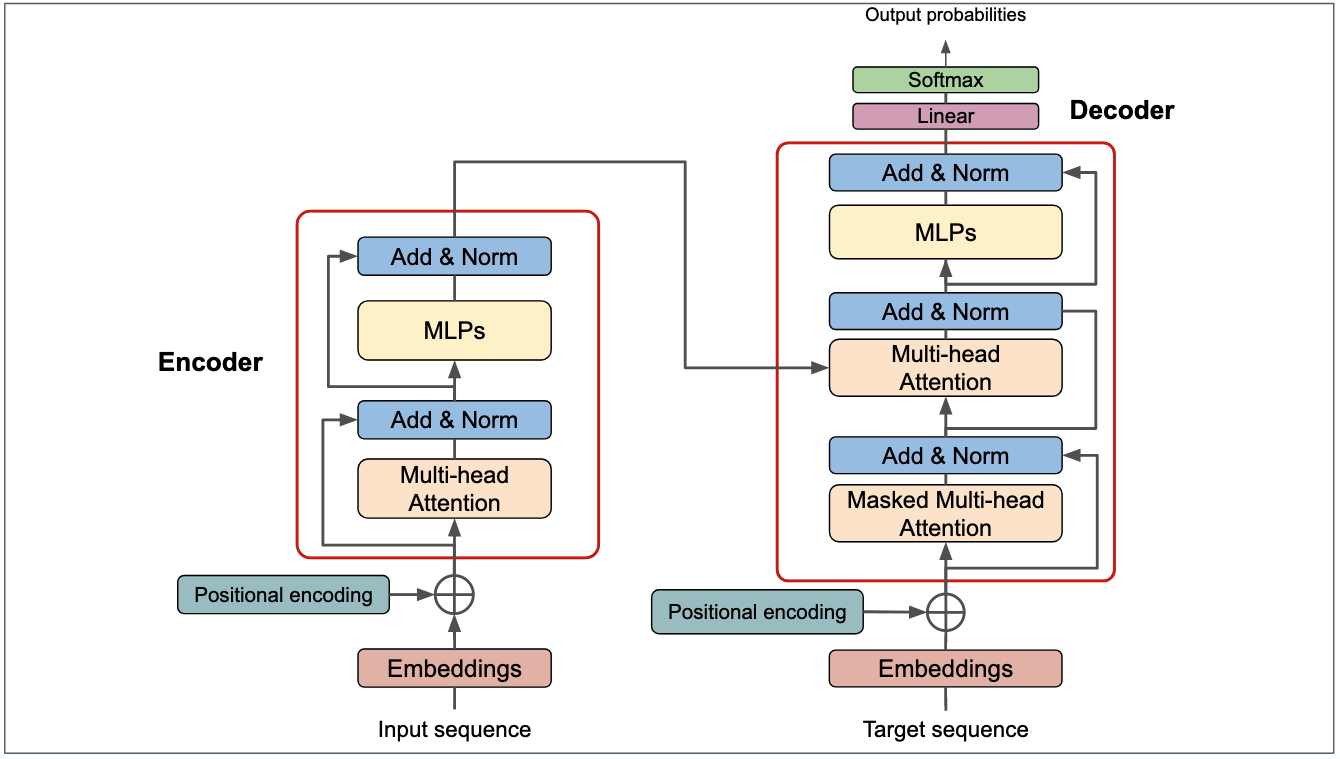

The transformer architecture consists of two main components:

1. **Encoder**: Processes the input sequence and builds representations
2. **Decoder**: Generates the output sequence based on the encoder's representations

Each encoder and decoder layer contains:
- Multi-head attention mechanisms
- Feed-forward neural networks
- Residual connections and layer normalization

Now, let's delve into each component in detail.

## 2. Token and Positional Embeddings

In transformer models, we first convert input tokens (words) into embeddings. However, unlike RNNs, transformers have no inherent notion of sequence order. To address this, we add positional encodings to the embeddings.

### 2.1 Mathematical Formulation

The positional encoding is defined as:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Where:
- $pos$ is the position in the sequence
- $i$ is the dimension
- $d_{model}$ is the embedding dimension

These sinusoidal functions have a specific wavelength hierarchy, allowing the model to attend to relative positions.

### 2.2 Implementation and Visualization

tensor([1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
        3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
        1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04])


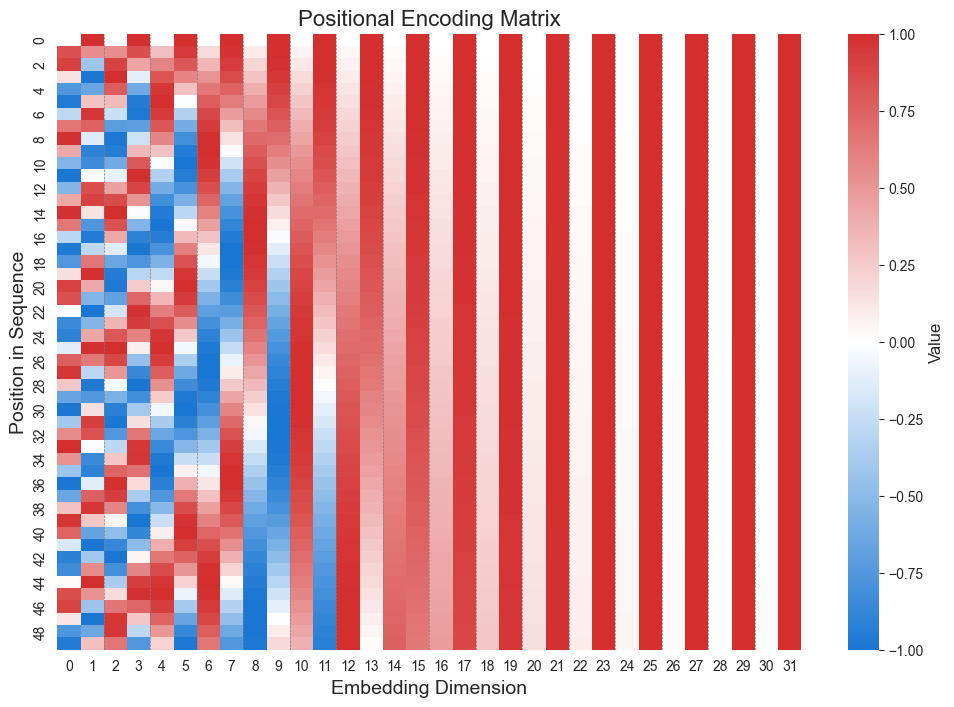

In [3]:
def get_positional_encoding(seq_len, d_model):
    """
    Create positional encodings for the input.
    
    Args:
        seq_len: Length of the sequence
        d_model: Dimensionality of the model
        
    Returns:
        Positional encoding of shape (seq_len, d_model)
    """
    # Create a matrix of shape (seq_len, d_model)
    pe = torch.zeros(seq_len, d_model)
    
    # Create a vector of shape (seq_len, 1)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    
    # Create a vector for the division term
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    print(div_term)
    
    # Apply sine to even indices
    pe[:, 0::2] = torch.sin(position * div_term)
    
    # Apply cosine to odd indices
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

def plot_positional_encoding(pe, title="Positional Encoding"):
    """Visualize the positional encoding matrix"""
    plt.figure(figsize=(12, 8))
    
    # Create a custom colormap that transitions from blue to white to red
    cmap = LinearSegmentedColormap.from_list('BrBG', ['#1976D2', 'white', '#D32F2F'])
    
    ax = sns.heatmap(
        pe, 
        cmap=cmap,
        center=0,
        vmin=-1.0, 
        vmax=1.0,
        cbar_kws={"label": "Value"}
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel('Embedding Dimension', fontsize=14)
    plt.ylabel('Position in Sequence', fontsize=14)
    
    # Add vertical lines to separate dimension pairs
    for i in range(2, pe.shape[1], 2):
        plt.axvline(x=i, color='grey', linestyle='--', linewidth=0.5)
        
    plt.show()

# Create and visualize positional encodings
seq_len = 50  # Sequence length
d_model = 32  # Embedding dimension

pe = get_positional_encoding(seq_len, d_model)
plot_positional_encoding(pe.numpy(), "Positional Encoding Matrix")

### 🔍 **What This Figure Shows**

Each **row** = a **position** in the input sequence (from position `0` to `49`).
Each **column** = a **dimension** in the positional encoding vector (from dimension `0` to `31`).
Each **cell's color** = the **value** of the positional encoding for that `(position, dimension)`.

* **Red = positive values**,
* **Blue = negative values**,
* **White = values close to zero**.

---

### 🧠 **Why These Patterns Emerge**

The positional encoding is based on sine and cosine functions of varying frequencies:

$$
\text{PE}_{\text{pos}, 2i} = \sin\left(\frac{\text{pos}}{10000^{2i / d_{\text{model}}}}\right), \quad
\text{PE}_{\text{pos}, 2i+1} = \cos\left(\frac{\text{pos}}{10000^{2i / d_{\text{model}}}}\right)
$$

#### ✅ Interpretation:

* **Even columns (0, 2, 4, …)** = sine waves.
* **Odd columns (1, 3, 5, …)** = cosine waves.
* **As dimension increases**, the **frequency of the wave decreases**:

  * Low-dimensional encodings (left) oscillate **fast** across positions (more stripes).
  * High-dimensional encodings (right) oscillate **slowly**, with wide bands of uniform red or blue.

---

### 🧭 Key Observations from Your Plot

1. **Left side (dims 0–10)**:

   * High-frequency oscillations — rapid color changes.
   * These help distinguish **short-term positions** (e.g., 3 vs. 5).

2. **Middle dimensions (\~10–20)**:

   * Lower frequencies — wider banding.
   * Encodes **medium-range** position differences.

3. **Right side (dims 20+)**:

   * Very low frequency — nearly flat values (close to 1 or 0 for all positions).
   * Helps model **long-term** or **global** position relationships.

---

### 🧪 Why Use This Encoding?

It enables the Transformer (which is inherently position-agnostic) to:

* Incorporate **order** into the model,
* Let the attention mechanism infer **relative** and **absolute** positions.

### 2.3 Understanding the Patterns

Let's visualize specific dimensions to better understand the pattern:

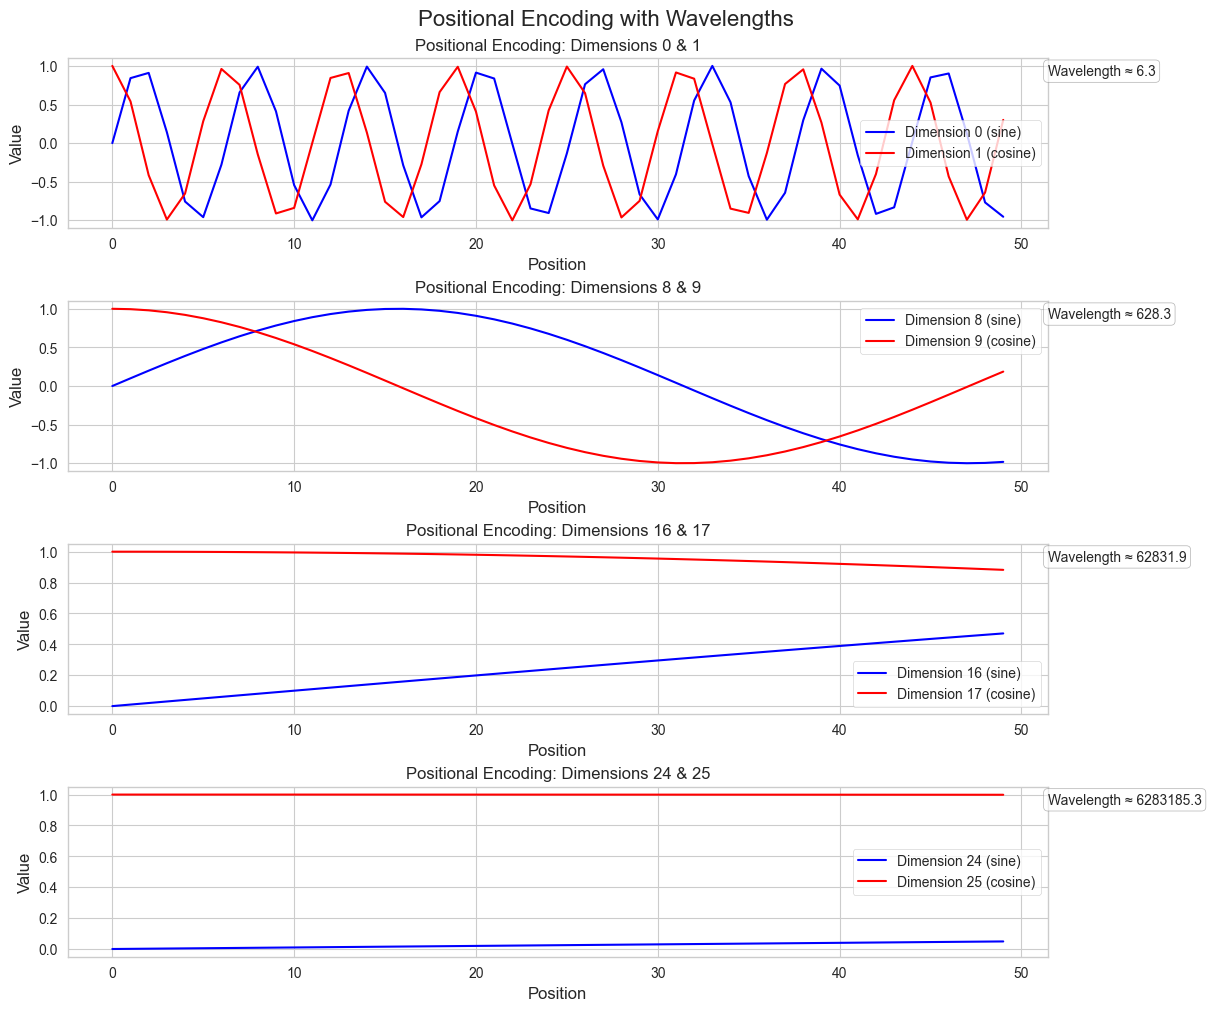

In [4]:
import torch
import math
import matplotlib.pyplot as plt

def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

def compute_wavelength(i, d_model):
    return 2 * math.pi * math.pow(10000, 2 * i / d_model)

def plot_encoding_with_wavelengths(pe, dims, d_model):
    seq_len = pe.shape[0]
    num_plots = len(dims)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 2.5 * num_plots), constrained_layout=True)

    if num_plots == 1:
        axes = [axes]  # Ensure iterable

    for idx, dim in enumerate(dims):
        ax = axes[idx]
        sin_dim = dim
        cos_dim = dim + 1

        wavelength = compute_wavelength(dim, d_model)
        ax.plot(range(seq_len), pe[:, sin_dim].numpy(), label=f"Dimension {sin_dim} (sine)", color="blue")
        ax.plot(range(seq_len), pe[:, cos_dim].numpy(), label=f"Dimension {cos_dim} (cosine)", color="red")
        ax.set_title(f"Positional Encoding: Dimensions {sin_dim} & {cos_dim}", fontsize=12)
        ax.set_ylabel("Value")
        ax.set_xlabel("Position")
        ax.legend()
        ax.grid(True)

        # Annotate wavelength
        ax.annotate(f"Wavelength ≈ {wavelength:.1f}", xy=(1, 0.9), xycoords="axes fraction", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.6))

    plt.suptitle("Positional Encoding with Wavelengths", fontsize=16)
    plt.show()

# Parameters
seq_len = 50
d_model = 32
dims_to_plot = [0, 8, 16, 24]  # Even dimensions; will pair with +1 for cosine

# Compute and plot
pe = get_positional_encoding(seq_len, d_model)
plot_encoding_with_wavelengths(pe, dims_to_plot, d_model)



### 📽️ Animated Positional Encoding in Transformers

This animation shows how **each embedding dimension** in a sinusoidal positional encoding changes across **token positions**.

- **X-axis**: Position of the token in the input sequence.
- **Y-axis**: Value of the positional encoding.
- Each frame corresponds to a different embedding dimension (from 0 to 31).

✅ Lower dimensions vary **faster** (high frequency, short wavelength).  
✅ Higher dimensions vary **slower** (low frequency, long wavelength).

This allows the model to encode both fine-grained local position and coarse global position within a sequence.


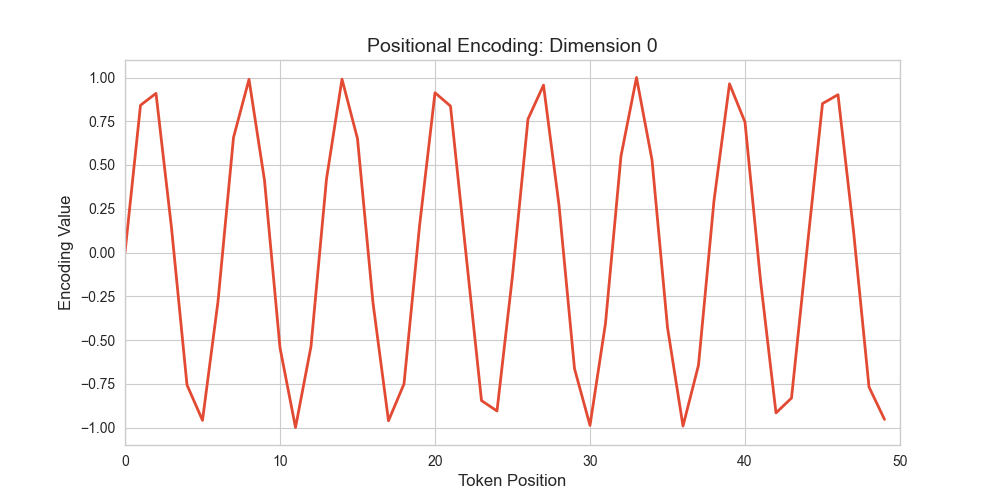

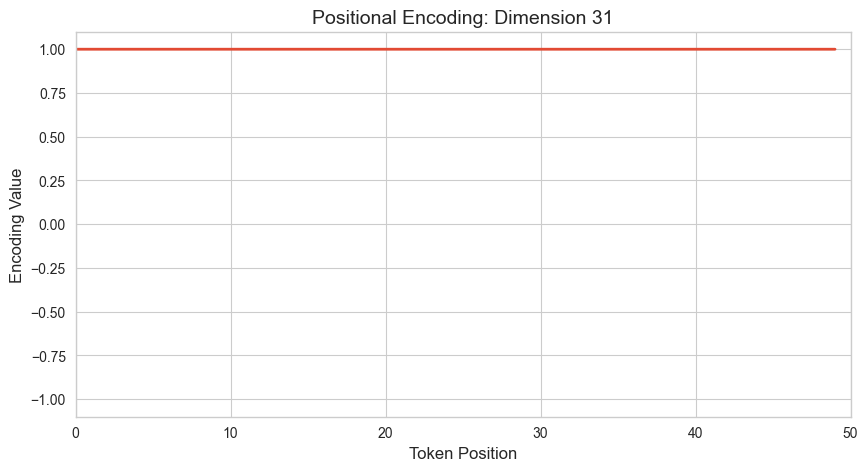

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image, display, Markdown

def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
    angle_rads = pos * angle_rates
    pos_encoding = np.zeros_like(angle_rads)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return pos_encoding

# Parameters
SEQ_LEN = 50
D_MODEL = 32
pos_enc = get_positional_encoding(SEQ_LEN, D_MODEL)

# Create animation
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, SEQ_LEN)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel("Token Position")
ax.set_ylabel("Encoding Value")

def init():
    line.set_data([], [])
    return line,

def animate(dim):
    y = pos_enc[:, dim]
    line.set_data(np.arange(SEQ_LEN), y)
    ax.set_title(f"Positional Encoding: Dimension {dim}", fontsize=14)
    return line,

ani = animation.FuncAnimation(
    fig, animate, init_func=init, frames=D_MODEL, interval=400, blit=True
)

# Save the animation
gif_path = "positional_encoding_animation.gif"
ani.save(gif_path, writer="pillow")

# Display Markdown explanation and animation inline
display(Markdown("""
### 📽️ Animated Positional Encoding in Transformers

This animation shows how **each embedding dimension** in a sinusoidal positional encoding changes across **token positions**.

- **X-axis**: Position of the token in the input sequence.
- **Y-axis**: Value of the positional encoding.
- Each frame corresponds to a different embedding dimension (from 0 to 31).

✅ Lower dimensions vary **faster** (high frequency, short wavelength).  
✅ Higher dimensions vary **slower** (low frequency, long wavelength).

This allows the model to encode both fine-grained local position and coarse global position within a sequence.
"""))

display(Image(filename=gif_path))


### 2.4 Key Properties of Positional Encodings

1. **Unique Patterns**: Each position gets a unique encoding pattern
2. **Fixed Offset Property**: For any fixed offset k, PE(pos+k) can be represented as a linear function of PE(pos)
3. **Wavelength Hierarchy**: Different dimensions encode position at different resolutions, from fine to coarse

The token embeddings and positional encodings are combined by simple addition:

$$\text{Input Embedding} = \text{Token Embedding} + \text{Positional Encoding}$$

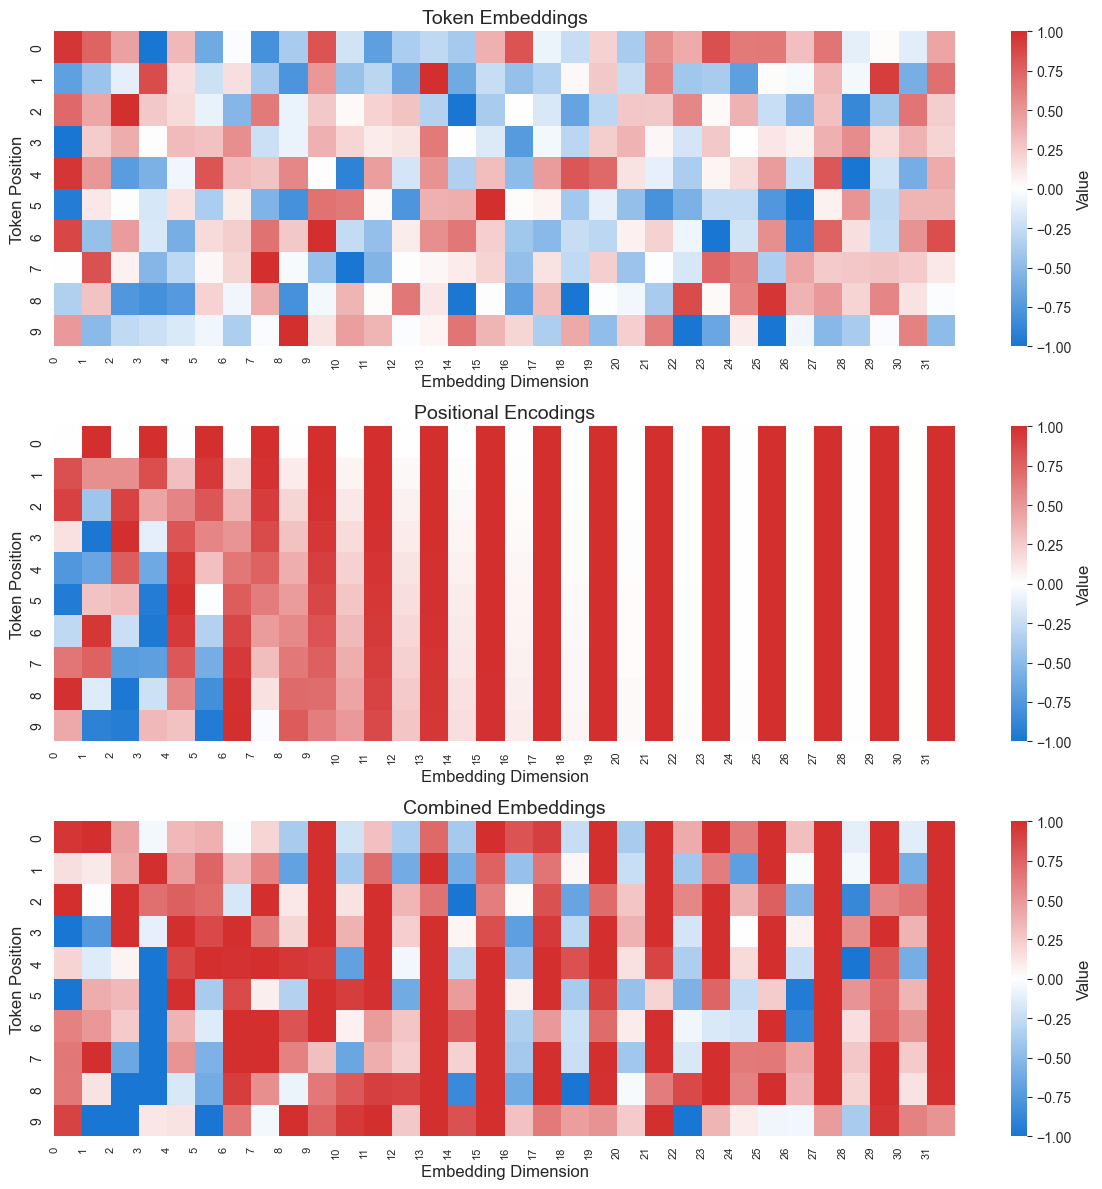

In [6]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math

def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

def visualize_embedding_with_position(seq_len=10, d_model=32):
    torch.manual_seed(42)  # Reproducibility

    # Create random token embeddings
    token_embeddings = torch.randn(seq_len, d_model) * 0.5

    # Create positional encodings
    pos_encodings = get_positional_encoding(seq_len, d_model)

    # Combine them
    combined = token_embeddings + pos_encodings

    # Visualize
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    cmap = LinearSegmentedColormap.from_list('BrBG', ['#1976D2', 'white', '#D32F2F'])

    titles = ["Token Embeddings", "Positional Encodings", "Combined Embeddings"]
    data = [token_embeddings, pos_encodings, combined]

    for ax, matrix, title in zip(axes, data, titles):
        sns.heatmap(matrix, ax=ax, cmap=cmap, center=0, vmin=-1, vmax=1, cbar_kws={"label": "Value"})
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Embedding Dimension")
        ax.set_ylabel("Token Position")
        ax.set_xticks(range(d_model))
        ax.set_xticklabels(range(d_model), rotation=90, fontsize=8)

    plt.tight_layout()
    plt.show()

visualize_embedding_with_position()


## 🔁 3. Self-Attention Mechanism

Self-attention is the mechanism that allows the model to **dynamically weigh the importance of other tokens** when computing a representation for a specific token in the sequence. This enables contextual understanding, long-range dependency modeling, and permutation-invariant learning.

---

### 🧮 3.1 Mathematical Formulation

Given an input sequence of token embeddings $X \in \mathbb{R}^{n \times d_{\text{model}}}$, the **self-attention** mechanism projects these into three separate spaces:

$$
Q = XW^Q,\quad K = XW^K,\quad V = XW^V
$$

Where:

* $W^Q, W^K, W^V \in \mathbb{R}^{d_{\text{model}} \times d_k}$ are learnable weight matrices,
* $Q, K, V \in \mathbb{R}^{n \times d_k}$ represent **queries**, **keys**, and **values** respectively,
* $n$ is the sequence length.

The **scaled dot-product attention** is then computed:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right) V
$$

#### 🔍 Explanation:

* $QK^\top$ gives a **score matrix** (how much each token attends to others),
* Division by $\sqrt{d_k}$ **stabilizes gradients** by preventing large dot products,
* `softmax` ensures the attention weights are normalized (sum to 1 for each token),
* The result is a **weighted sum of values** (contextualized representation).

---

### 🧠 3.2 Multi-Head Attention

Instead of using a single attention function, **multi-head attention** performs attention computations in **parallel**, allowing the model to **attend to information from different subspaces**.

Each head $i$ is computed independently:

$$
\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

The outputs of all $h$ heads are concatenated and linearly transformed:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h) W^O
$$

Where:

* $W^Q_i, W^K_i, W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$,
* Typically $d_k = d_v = d_{\text{model}} / h$, so concatenation preserves dimension.

---

### 🛠 3.3 Implementation Intuition

In practice:

* Self-attention is computed **for all tokens in parallel** using batched matrix multiplication.
* Multi-head attention is implemented efficiently by **stacking and reshaping** tensors.
* The result is a tensor of shape $(n, d_{\text{model}})$, where each token now holds context-aware features.

---

### 🔄 Summary

Self-attention allows each token to:

* **Query all other tokens** to decide what to focus on,
* Use **learned projections** to model relationships,
* **Combine this information** into a contextualized output.

This is what gives the Transformer its power in modeling **dependencies across arbitrary distances** — unlike RNNs, which process tokens sequentially.


In [7]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import nn
class SelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads"

        # Projection layers
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, query, key=None, value=None, mask=None, return_attention=False):
        if key is None: key = query
        if value is None: value = query

        batch_size = query.size(0)
        tgt_len = query.size(1)
        src_len = key.size(1)

        def shape(x):
            return x.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        Q = shape(self.q_linear(query))  # (B, num_heads, tgt_len, head_dim)
        K = shape(self.k_linear(key))    # (B, num_heads, src_len, head_dim)
        V = shape(self.v_linear(value))  # (B, num_heads, src_len, head_dim)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (B, heads, tgt_len, src_len)

        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(0).unsqueeze(1)  # (1, 1, seq, seq)
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)  # (B, 1, tgt_len, src_len)
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attn_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, V)  # (B, heads, tgt_len, head_dim)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, tgt_len, self.d_model)
        out = self.out(context)

        return (out, attn_weights) if return_attention else out


### 3.3 Visual Explanation

Let's illustrate how self-attention works:

interactive(children=(IntSlider(value=0, description='head_idx', max=3), Output()), _dom_classes=('widget-inte…

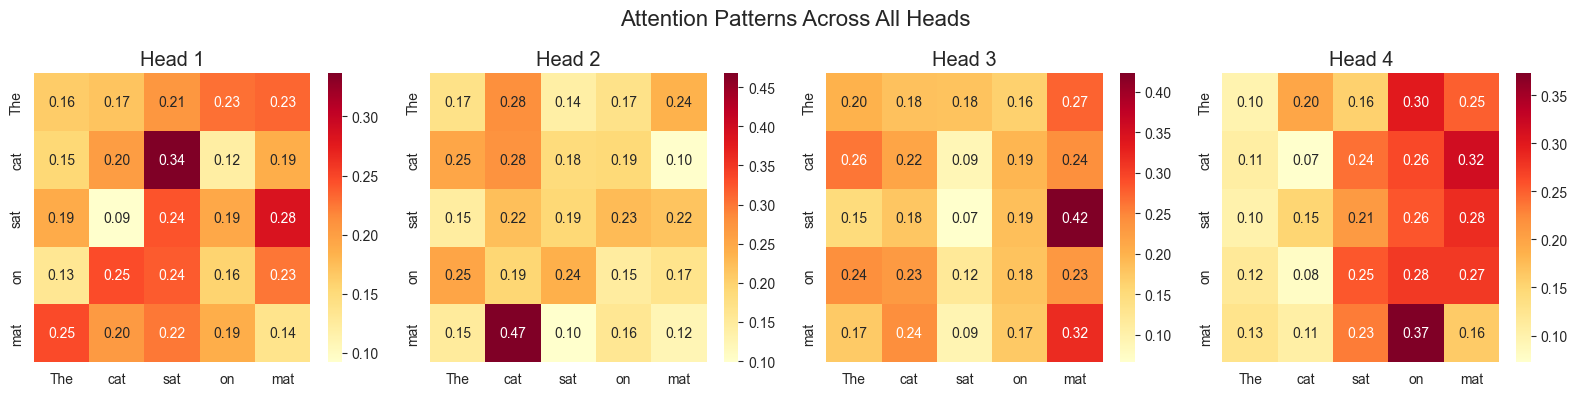

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import interact


def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

def plot_attention_steps(x, q, k, v, output, tokens, head_idx):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f"Self-Attention Visualization — Head {head_idx+1}", fontsize=18)

    # 1. Input Embeddings
    sns.heatmap(x[0].detach().numpy(), cmap='viridis', ax=axes[0, 0])
    axes[0, 0].set_title("1. Input Embeddings + Positional")
    axes[0, 0].set_ylabel("Token")
    axes[0, 0].set_yticks(np.arange(len(tokens)) + 0.5)
    axes[0, 0].set_yticklabels(tokens, rotation=0)

    # 2. Query Projection
    sns.heatmap(q[0, :, head_idx].detach().numpy(), cmap='Blues', ax=axes[0, 1])
    axes[0, 1].set_title(f"2. Query Projection (Head {head_idx+1})")
    axes[0, 1].set_yticks(np.arange(len(tokens)) + 0.5)
    axes[0, 1].set_yticklabels(tokens, rotation=0)

    # 3. Scaled Dot Product QKᵀ
    qk = torch.matmul(q[0, :, head_idx], k[0, :, head_idx].transpose(0, 1)) / math.sqrt(q.shape[-1])
    sns.heatmap(qk.detach().numpy(), cmap='Reds', ax=axes[1, 0], annot=True, fmt=".2f")
    axes[1, 0].set_title("3. Scaled QKᵀ / √d_k")
    axes[1, 0].set_xticks(np.arange(len(tokens)) + 0.5)
    axes[1, 0].set_xticklabels(tokens, rotation=45)
    axes[1, 0].set_yticks(np.arange(len(tokens)) + 0.5)
    axes[1, 0].set_yticklabels(tokens, rotation=0)

    # 4. Softmax Weights
    attn = F.softmax(qk, dim=-1)
    sns.heatmap(attn.detach().numpy(), cmap='Oranges', ax=axes[1, 1], annot=True, fmt=".2f")
    axes[1, 1].set_title("4. Attention Weights (Softmax)")
    axes[1, 1].set_xticks(np.arange(len(tokens)) + 0.5)
    axes[1, 1].set_xticklabels(tokens, rotation=45)
    axes[1, 1].set_yticks(np.arange(len(tokens)) + 0.5)
    axes[1, 1].set_yticklabels(tokens, rotation=0)

    # 5. Weighted Values
    weighted_v = torch.matmul(attn, v[0, :, head_idx])
    sns.heatmap(weighted_v.detach().numpy(), cmap='Greens', ax=axes[2, 0])
    axes[2, 0].set_title("5. Weighted Sum of Values")
    axes[2, 0].set_yticks(np.arange(len(tokens)) + 0.5)
    axes[2, 0].set_yticklabels(tokens, rotation=0)

    # 6. Final Output
    sns.heatmap(output[0].detach().numpy(), cmap='Purples', ax=axes[2, 1])
    axes[2, 1].set_title("6. Final Output After Attention")
    axes[2, 1].set_yticks(np.arange(len(tokens)) + 0.5)
    axes[2, 1].set_yticklabels(tokens, rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

def visualize_attention_heads(attention_weights, tokens):
    num_heads = attention_weights.shape[1]
    fig, axes = plt.subplots(1, num_heads, figsize=(4 * num_heads, 4))
    fig.suptitle("Attention Patterns Across All Heads", fontsize=16)

    for h in range(num_heads):
        sns.heatmap(attention_weights[0, h].detach().numpy(), cmap='YlOrRd', annot=True, fmt=".2f",
                    xticklabels=tokens, yticklabels=tokens, ax=axes[h])
        axes[h].set_title(f"Head {h+1}")
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)
    plt.show()

def visualize_self_attention_process():
    seq_len, d_model, num_heads = 5, 32, 4
    tokens = ["The", "cat", "sat", "on", "mat"]
    torch.manual_seed(42)

    x = torch.randn(1, seq_len, d_model)
    pe = get_positional_encoding(seq_len, d_model)
    x = x + pe[:seq_len, :]

    self_attn = SelfAttention(d_model, num_heads)
    output, attention_weights = self_attn(x, return_attention=True)

    with torch.no_grad():
        q = self_attn.q_linear(x).view(1, seq_len, num_heads, d_model // num_heads)
        k = self_attn.k_linear(x).view(1, seq_len, num_heads, d_model // num_heads)
        v = self_attn.v_linear(x).view(1, seq_len, num_heads, d_model // num_heads)

    if interact is not None:
        @interact(head_idx=(0, num_heads - 1))
        def interactive_plot(head_idx=0):
            plot_attention_steps(x, q, k, v, output, tokens, head_idx)
    else:
        plot_attention_steps(x, q, k, v, output, tokens, head_idx=0)

    visualize_attention_heads(attention_weights, tokens)

# Call the function
visualize_self_attention_process()

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact
import math

def self_attention_step_by_step(x, tokens, head_idx=0, token_idx=0):
    seq_len, d_model = x.shape[1], x.shape[2]
    num_heads = 4
    head_dim = d_model // num_heads

    # Simple QKV projection
    q_proj = torch.nn.Linear(d_model, d_model, bias=False)
    k_proj = torch.nn.Linear(d_model, d_model, bias=False)
    v_proj = torch.nn.Linear(d_model, d_model, bias=False)

    Q = q_proj(x).view(1, seq_len, num_heads, head_dim)
    K = k_proj(x).view(1, seq_len, num_heads, head_dim)
    V = v_proj(x).view(1, seq_len, num_heads, head_dim)

    q = Q[0, token_idx, head_idx]
    k = K[0, :, head_idx]
    v = V[0, :, head_idx]

    # Dot-product scores
    scores = torch.matmul(k, q) / math.sqrt(head_dim)
    weights = F.softmax(scores, dim=0)
    output = torch.matmul(weights, v)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Attention for token '{tokens[token_idx]}' (Head {head_idx+1})", fontsize=16)

    # 1. Attention Scores
    sns.heatmap(scores.unsqueeze(0).detach().numpy(), cmap='Reds', annot=True, fmt=".2f", ax=axes[0, 0],
                xticklabels=tokens)
    axes[0, 0].set_title("Dot Product Scores Q·K")
    axes[0, 0].set_yticks([])

    # 2. Softmax Weights
    sns.heatmap(weights.unsqueeze(0).detach().numpy(), cmap='Oranges', annot=True, fmt=".2f", ax=axes[0, 1],
                xticklabels=tokens)
    axes[0, 1].set_title("Softmax Attention Weights")
    axes[0, 1].set_yticks([])

    # 3. Value Vectors
    sns.heatmap(v.detach().numpy(), cmap='Greens', ax=axes[1, 0])
    axes[1, 0].set_title("All Value Vectors (V)")

    # 4. Output Vector
    sns.heatmap(output.unsqueeze(0).detach().numpy(), cmap='Purples', ax=axes[1, 1], annot=True, fmt=".2f")
    axes[1, 1].set_title("Output Vector (Weighted Sum)")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Sample Setup
tokens = ["The", "cat", "sat", "on", "mat"]
seq_len, d_model = len(tokens), 32
torch.manual_seed(0)
x = torch.randn(1, seq_len, d_model) + get_positional_encoding(seq_len, d_model)

# Run interactive animation
def attention_wrapper(head_idx=0, token_idx=0):
    self_attention_step_by_step(x=x, tokens=tokens, head_idx=head_idx, token_idx=token_idx)

interact(
    attention_wrapper,
    head_idx=(0, 3),
    token_idx=(0, len(tokens) - 1)
)



interactive(children=(IntSlider(value=0, description='head_idx', max=3), IntSlider(value=0, description='token…

<function __main__.attention_wrapper(head_idx=0, token_idx=0)>

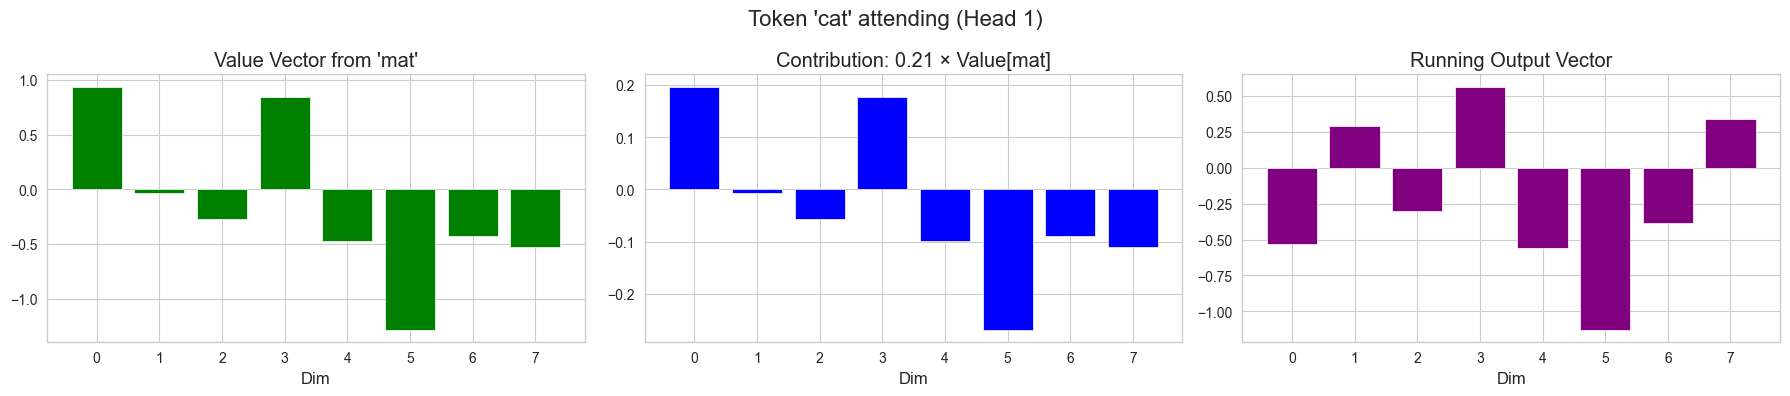

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from IPython.display import clear_output, display

def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

def animate_attention_plot(x, tokens, token_idx=1, head_idx=0, delay=1.0):
    seq_len, d_model = x.shape[1], x.shape[2]
    num_heads = 4
    head_dim = d_model // num_heads

    # Projection weights
    q_proj = torch.nn.Linear(d_model, d_model, bias=False)
    k_proj = torch.nn.Linear(d_model, d_model, bias=False)
    v_proj = torch.nn.Linear(d_model, d_model, bias=False)

    Q = q_proj(x).view(1, seq_len, num_heads, head_dim)
    K = k_proj(x).view(1, seq_len, num_heads, head_dim)
    V = v_proj(x).view(1, seq_len, num_heads, head_dim)

    q = Q[0, token_idx, head_idx]
    k = K[0, :, head_idx]
    v = V[0, :, head_idx]

    # Dot products and softmax
    scores = torch.matmul(k, q) / math.sqrt(head_dim)
    weights = F.softmax(scores, dim=0)

    partial_sum = torch.zeros_like(v[0])
    d_to_show = min(10, head_dim)

    for i in range(seq_len + 2):  # +2: show score/weights before and after values
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        fig.suptitle(f"Token '{tokens[token_idx]}' attending (Head {head_idx+1})", fontsize=16)

        if i == 0:
            # Step 1: Show scores
            axes[0].bar(tokens, scores.detach().numpy(), color='red')
            axes[0].set_title("Step 1: Dot Product Scores (Q·K)")
            axes[0].set_ylim(scores.detach().numpy().min() - 1, scores.detach().numpy().max() + 1)
            axes[1].axis("off")
            axes[2].axis("off")
        elif i == 1:
            # Step 2: Softmax weights
            axes[0].bar(tokens, weights.detach().numpy(), color='orange')
            axes[0].set_title("Step 2: Attention Weights (Softmax)")
            axes[0].set_ylim(0, 1)
            axes[1].axis("off")
            axes[2].axis("off")
        else:
            idx = i - 2
            contrib = weights[idx] * v[idx]
            partial_sum += contrib

            # Step 3: Show value vector
            axes[0].bar(range(d_to_show), v[idx][:d_to_show].detach().numpy(), color='green')
            axes[0].set_title(f"Value Vector from '{tokens[idx]}'")

            # Step 4: Show contribution (weighted value)
            axes[1].bar(range(d_to_show), contrib[:d_to_show].detach().numpy(), color='blue')
            axes[1].set_title(f"Contribution: {weights[idx]:.2f} × Value[{tokens[idx]}]")

            # Step 5: Show running output vector
            axes[2].bar(range(d_to_show), partial_sum[:d_to_show].detach().numpy(), color='purple')
            axes[2].set_title("Running Output Vector")

        for ax in axes:
            ax.set_xticks(range(d_to_show))
            ax.set_xlabel("Dim")

        plt.tight_layout()
        display(fig)
        plt.close(fig)
        time.sleep(delay)

# Example setup
tokens = ["The", "cat", "sat", "on", "mat"]
seq_len, d_model = len(tokens), 32
torch.manual_seed(0)
x = torch.randn(1, seq_len, d_model) + get_positional_encoding(seq_len, d_model)

# Run the animation (you can change token_idx and head_idx as needed)
animate_attention_plot(x, tokens, token_idx=1, head_idx=0, delay=1.2)


### 3.4 Understanding Self-Attention: Key Points

1. **Information Flow**: Each token can attend to all other tokens in the sequence
2. **Multiple Heads**: Allows the model to focus on different aspects of the sequence in parallel
3. **Computational Complexity**: $O(n^2 \cdot d)$, where $n$ is the sequence length and $d$ is the embedding dimension

## 4. Feed-Forward Networks

Each transformer block contains a feed-forward network after the attention layer.

### 4.1 Mathematical Formulation

The feed-forward network consists of two linear transformations with a ReLU activation in between:

$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

Where:
- $W_1$, $b_1$, $W_2$, $b_2$ are learnable parameters
- The inner dimension $d_{ff}$ is typically larger than the model dimension $d_{model}$

### 4.2 Implementation

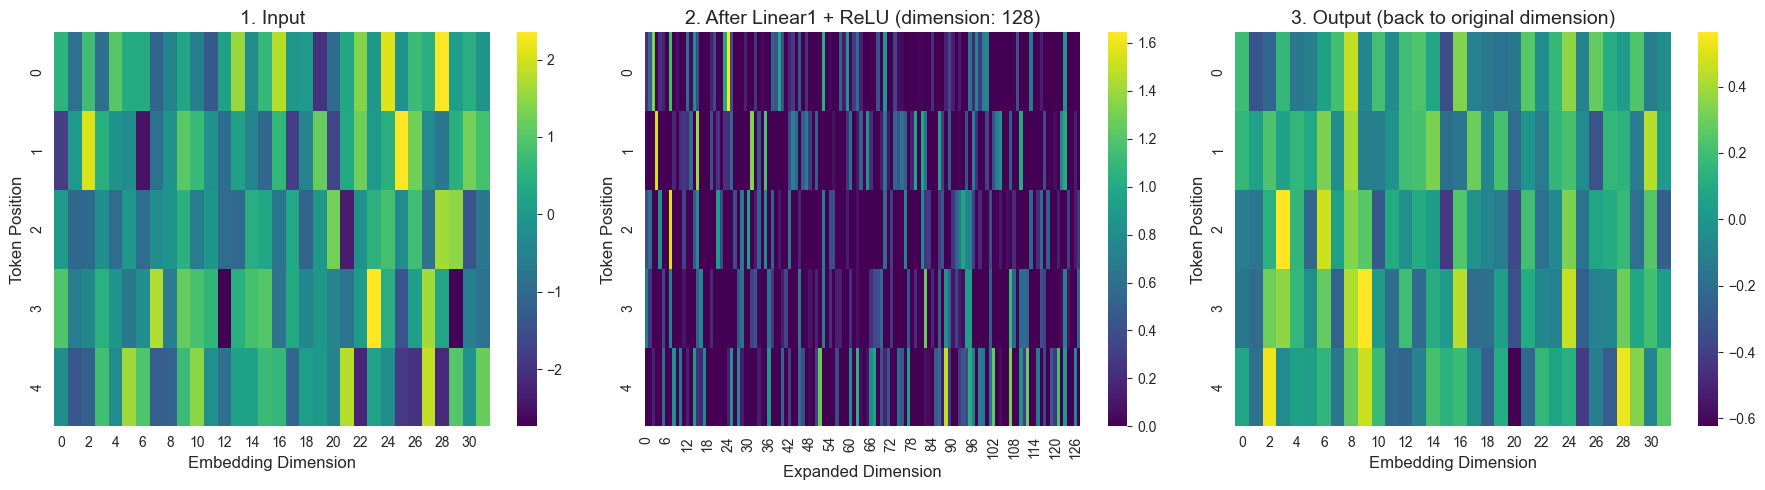

In [11]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x
        
def visualize_ffn_transformation():
    """Visualize how the feed-forward network transforms the input"""
    # Parameters
    d_model = 32
    d_ff = 128
    seq_len = 5
    
    # Create a feed-forward network
    ffn = FeedForward(d_model, d_ff)
    
    # Sample input
    x = torch.randn(1, seq_len, d_model)
    
    # Forward pass
    with torch.no_grad():
        # After first linear layer
        after_linear1 = F.relu(ffn.linear1(x))
        
        # Final output
        output = ffn(x)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Input
    sns.heatmap(x[0].numpy(), ax=axes[0], cmap='viridis')
    axes[0].set_title("1. Input", fontsize=14)
    axes[0].set_xlabel("Embedding Dimension")
    axes[0].set_ylabel("Token Position")
    
    # After first linear layer and ReLU
    sns.heatmap(after_linear1[0].numpy(), ax=axes[1], cmap='viridis')
    axes[1].set_title(f"2. After Linear1 + ReLU (dimension: {d_ff})", fontsize=14)
    axes[1].set_xlabel("Expanded Dimension")
    axes[1].set_ylabel("Token Position")
    
    # Output
    sns.heatmap(output[0].numpy(), ax=axes[2], cmap='viridis')
    axes[2].set_title("3. Output (back to original dimension)", fontsize=14)
    axes[2].set_xlabel("Embedding Dimension")
    axes[2].set_ylabel("Token Position")
    
    plt.tight_layout()
    plt.show()

visualize_ffn_transformation()

### 4.3 Purpose of the Feed-Forward Network

The feed-forward network serves several crucial purposes in the transformer architecture:

1. **Non-linearity**: Introduces non-linear transformations that increase the model's expressive power
2. **Feature Refinement**: Projects representations to a larger space (d_ff) where complex patterns can be learned
3. **Token-wise Processing**: Unlike attention, operates independently on each token's representation
4. **Parameter Efficiency**: Significant portion of model parameters, essential for model capacity

## 5. Layer Normalization and Residual Connections

Transformer models use layer normalization and residual connections to improve training stability and performance.

### 5.1 Layer Normalization

Layer normalization normalizes the inputs across the features:

$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$

Where:
- $\mu$ and $\sigma$ are the mean and standard deviation of the input
- $\gamma$ and $\beta$ are learnable parameters
- $\epsilon$ is a small constant for numerical stability

### 5.2 Residual Connections

Residual connections are simple addition operations that help with gradient flow:

$\text{Output} = \text{LayerNorm}(x + \text{Sublayer}(x))$

### 5.3 Visual Explanation

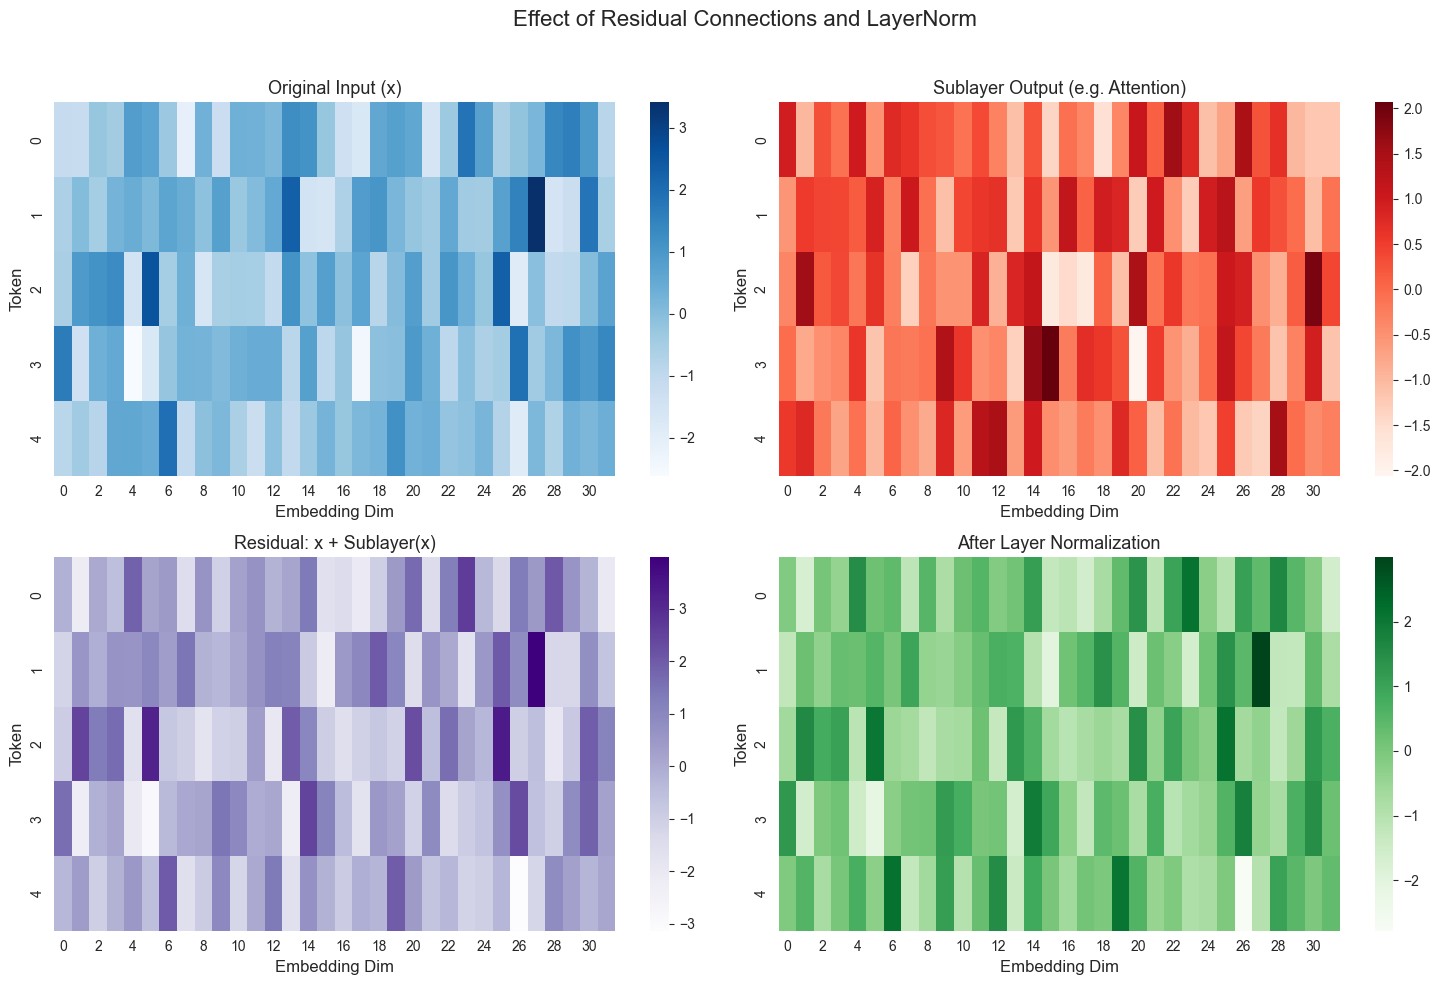

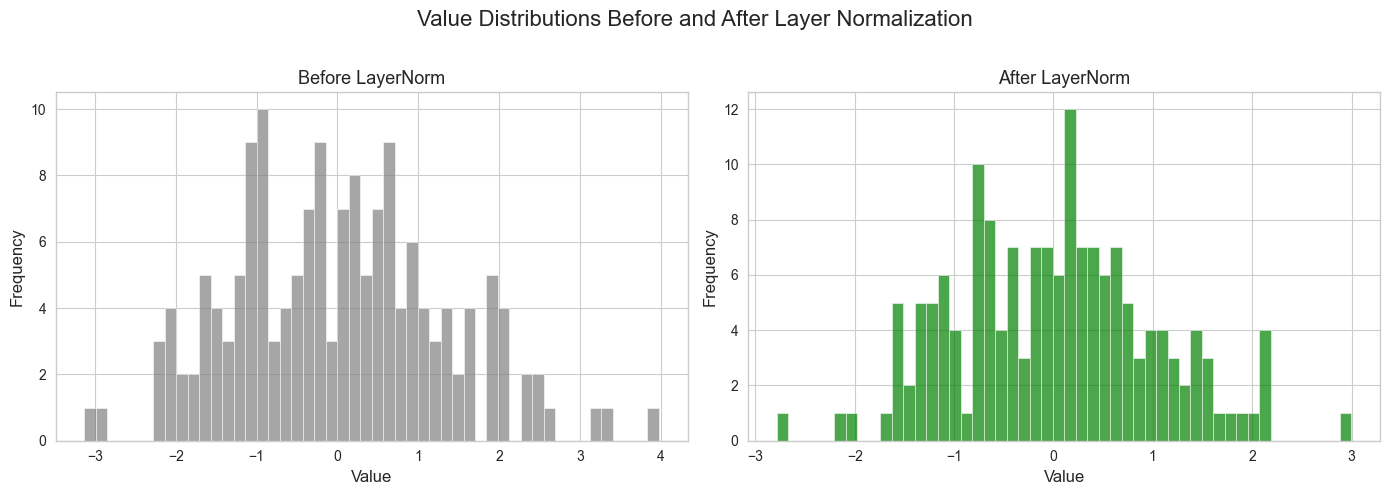

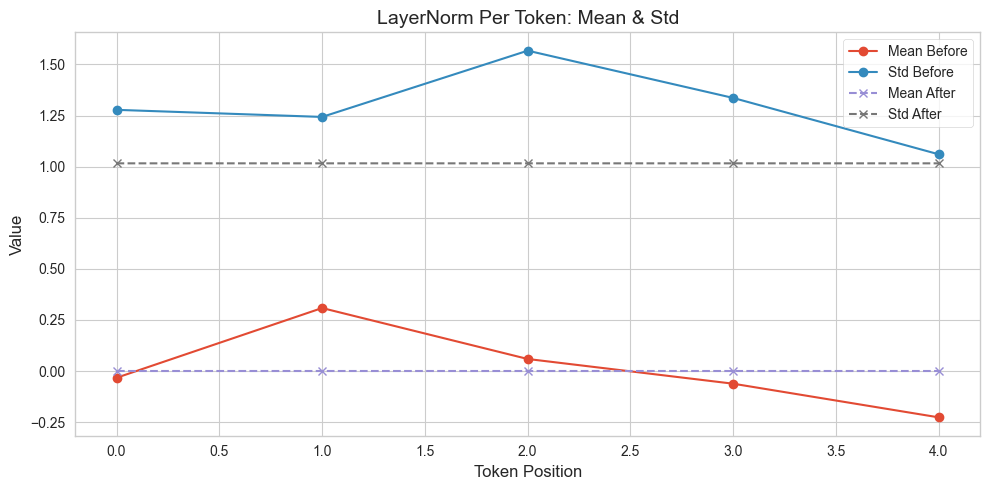

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_layernorm_residual():
    d_model = 32
    seq_len = 5
    torch.manual_seed(0)

    # Simulated inputs
    x = torch.randn(1, seq_len, d_model)
    sublayer_output = torch.randn(1, seq_len, d_model)

    # Residual and LayerNorm
    residual = x + sublayer_output
    layer_norm = nn.LayerNorm(d_model)
    norm_output = layer_norm(residual)

    # Heatmap Grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    sns.heatmap(x[0].numpy(), ax=axes[0, 0], cmap='Blues')
    axes[0, 0].set_title("Original Input (x)", fontsize=13)
    axes[0, 0].set_ylabel("Token")
    axes[0, 0].set_xlabel("Embedding Dim")

    sns.heatmap(sublayer_output[0].numpy(), ax=axes[0, 1], cmap='Reds')
    axes[0, 1].set_title("Sublayer Output (e.g. Attention)", fontsize=13)
    axes[0, 1].set_ylabel("Token")
    axes[0, 1].set_xlabel("Embedding Dim")

    sns.heatmap(residual[0].numpy(), ax=axes[1, 0], cmap='Purples')
    axes[1, 0].set_title("Residual: x + Sublayer(x)", fontsize=13)
    axes[1, 0].set_ylabel("Token")
    axes[1, 0].set_xlabel("Embedding Dim")

    sns.heatmap(norm_output[0].detach().numpy(), ax=axes[1, 1], cmap='Greens')
    axes[1, 1].set_title("After Layer Normalization", fontsize=13)
    axes[1, 1].set_ylabel("Token")
    axes[1, 1].set_xlabel("Embedding Dim")

    plt.suptitle("Effect of Residual Connections and LayerNorm", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Histogram Comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(residual[0].detach().flatten().numpy(), bins=50, color='gray', alpha=0.7)
    axes[0].set_title("Before LayerNorm", fontsize=13)
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(norm_output[0].detach().flatten().numpy(), bins=50, color='green', alpha=0.7)
    axes[1].set_title("After LayerNorm", fontsize=13)
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Frequency")

    plt.suptitle("Value Distributions Before and After Layer Normalization", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Line plot: Per-token mean/std before and after LayerNorm
    means_before = residual[0].mean(dim=1).numpy()
    stds_before = residual[0].std(dim=1).numpy()
    means_after = norm_output[0].detach().mean(dim=1).numpy()
    stds_after = norm_output[0].detach().std(dim=1).numpy()

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    tokens = np.arange(seq_len)

    ax.plot(tokens, means_before, label="Mean Before", marker='o')
    ax.plot(tokens, stds_before, label="Std Before", marker='o')
    ax.plot(tokens, means_after, label="Mean After", linestyle='--', marker='x')
    ax.plot(tokens, stds_after, label="Std After", linestyle='--', marker='x')

    ax.set_title("LayerNorm Per Token: Mean & Std", fontsize=14)
    ax.set_xlabel("Token Position")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

visualize_layernorm_residual()


Mean absolute grad (no residual): 1.02e-08
Mean absolute grad (with residual): 1.02e-08


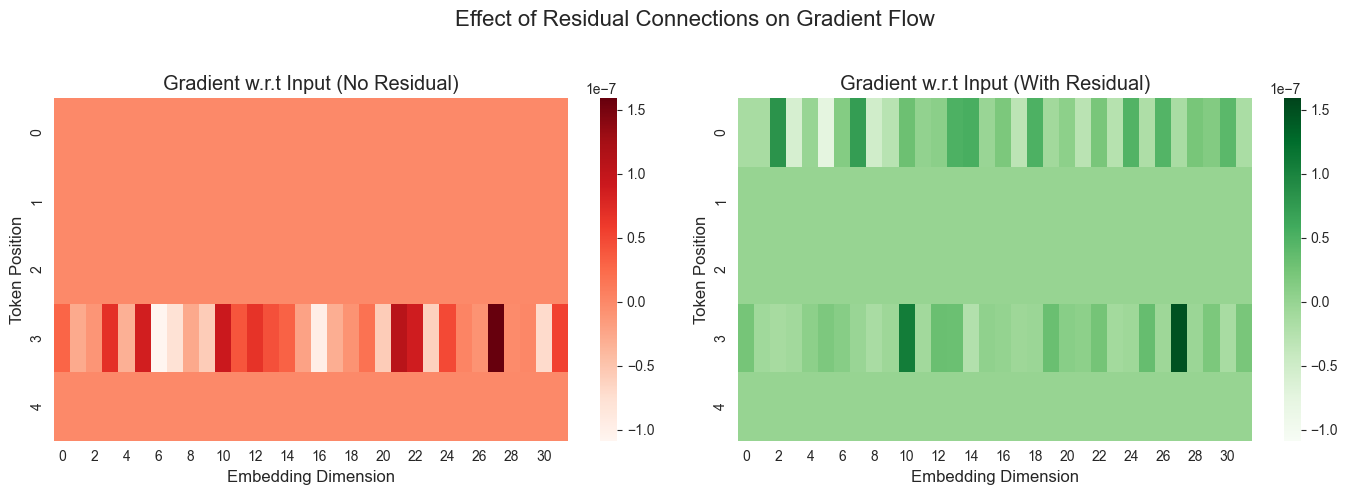

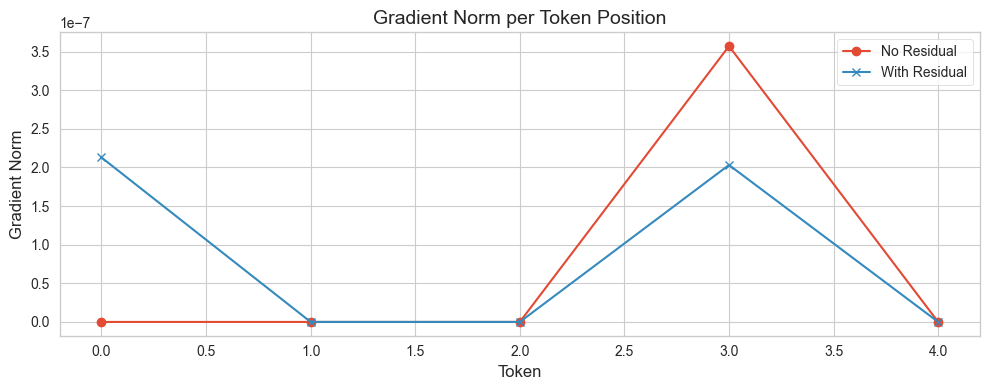

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def gradient_flow_comparison():
    torch.manual_seed(0)
    d_model = 32
    seq_len = 5

    class ToySublayer(nn.Module):
        def __init__(self, d_model):
            super().__init__()
            self.linear = nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.GELU()
            )

        def forward(self, x):
            return self.linear(x)

    sublayer = ToySublayer(d_model)
    layer_norm = nn.LayerNorm(d_model)

    # Input
    x = torch.randn(1, seq_len, d_model, requires_grad=True)

    # ---- Case 1: Without Residual ----
    out1 = layer_norm(sublayer(x))
    loss1 = out1.sum()
    loss1.backward(retain_graph=True)
    grad_without = x.grad.detach().clone()
    x.grad.zero_()

    # ---- Case 2: With Residual ----
    out2 = layer_norm(x + sublayer(x))
    loss2 = out2.sum()
    loss2.backward()
    grad_with = x.grad.detach().clone()

    # ---- Print Gradient Summary ----
    print(f"Mean absolute grad (no residual): {grad_without.abs().mean():.2e}")
    print(f"Mean absolute grad (with residual): {grad_with.abs().mean():.2e}")

    # ---- Visualize Heatmaps ----
    vmin = min(grad_without.min().item(), grad_with.min().item())
    vmax = max(grad_without.max().item(), grad_with.max().item())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(grad_without[0].numpy(), ax=axes[0], cmap="Reds", vmin=vmin, vmax=vmax)
    axes[0].set_title("Gradient w.r.t Input (No Residual)")
    axes[0].set_xlabel("Embedding Dimension")
    axes[0].set_ylabel("Token Position")

    sns.heatmap(grad_with[0].numpy(), ax=axes[1], cmap="Greens", vmin=vmin, vmax=vmax)
    axes[1].set_title("Gradient w.r.t Input (With Residual)")
    axes[1].set_xlabel("Embedding Dimension")
    axes[1].set_ylabel("Token Position")

    plt.suptitle("Effect of Residual Connections on Gradient Flow", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # ---- Gradient Norm per Token ----
    norms_no = grad_without.norm(dim=-1).squeeze().numpy()
    norms_res = grad_with.norm(dim=-1).squeeze().numpy()

    plt.figure(figsize=(10, 4))
    plt.plot(norms_no, label="No Residual", marker='o')
    plt.plot(norms_res, label="With Residual", marker='x')
    plt.title("Gradient Norm per Token Position", fontsize=14)
    plt.xlabel("Token")
    plt.ylabel("Gradient Norm")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

gradient_flow_comparison()


### 5.4 Key Benefits

1. **Training Stability**: Layer normalization helps stabilize training by normalizing activations
2. **Deeper Networks**: Residual connections allow for training deeper networks by providing shortcut paths for gradients
3. **Feature Preservation**: Residual connections preserve features from earlier layers

## 6. Encoder and Decoder Layers

Now that we've covered the individual components, let's put them together into encoder and decoder layers.

### 6.1 Encoder Layer

The encoder layer consists of:
1. Multi-head self-attention
2. Feed-forward network
3. Layer normalization and residual connections

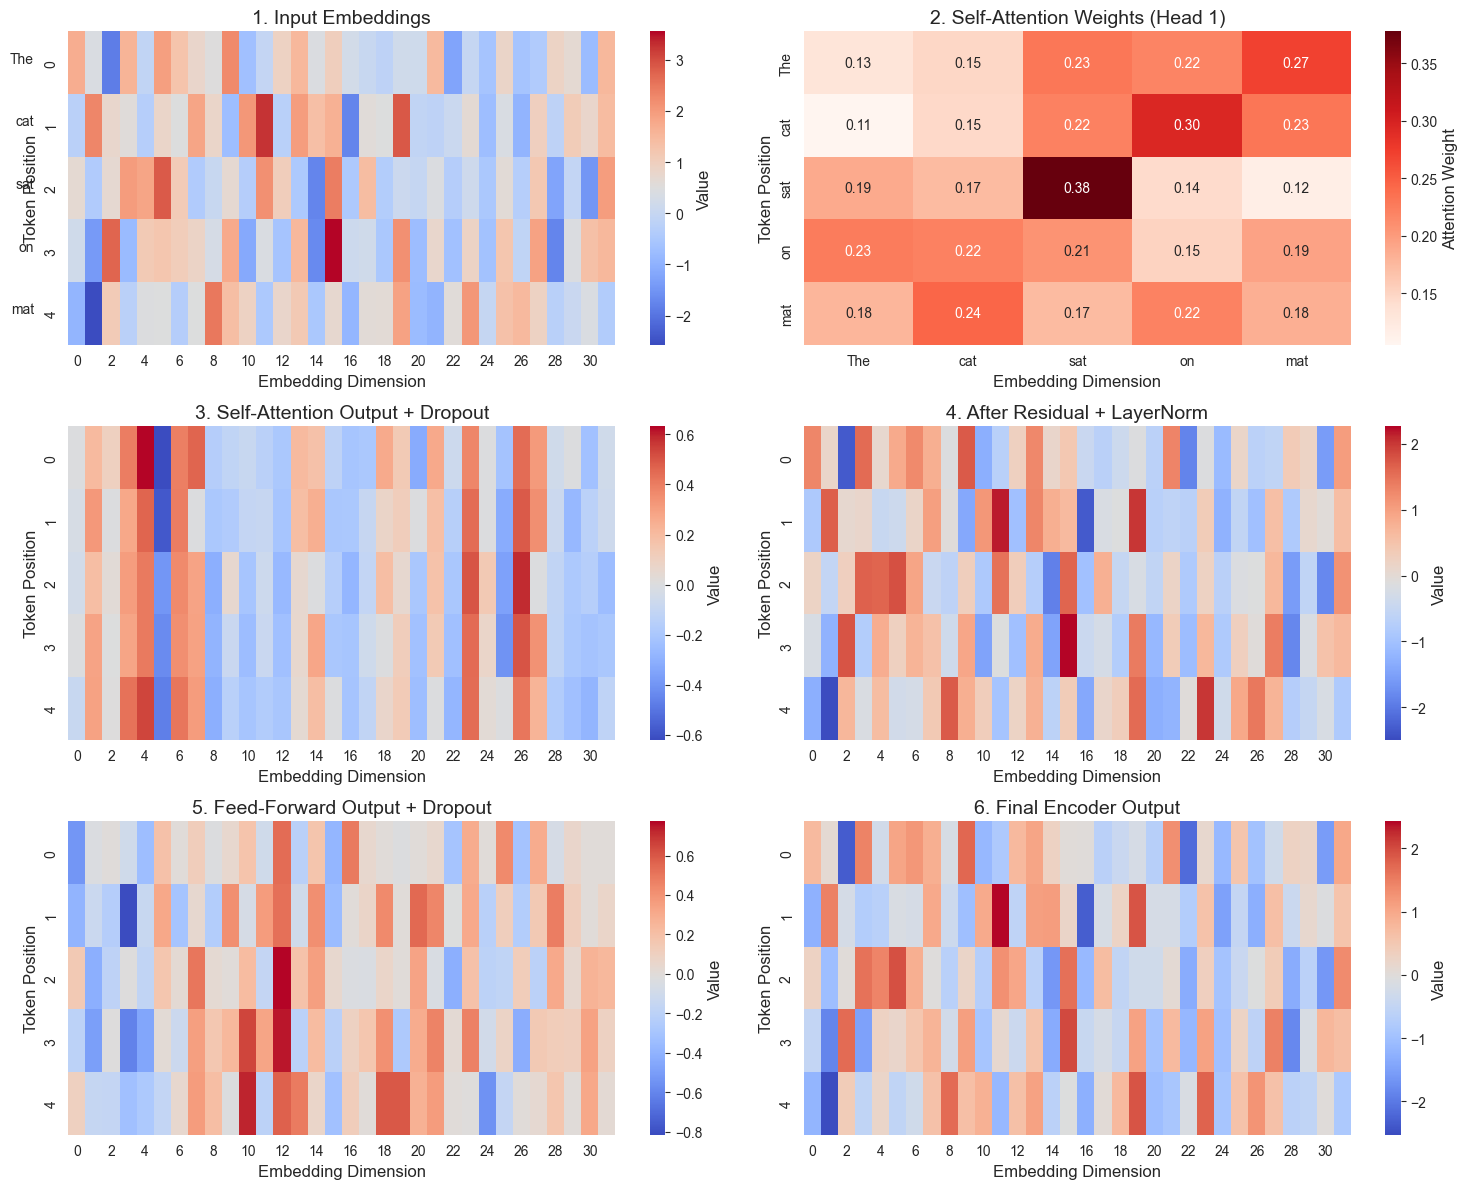

In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Assumes get_positional_encoding, SelfAttention, FeedForward are defined

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = SelfAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, src_mask=None, return_attention=False):
        self_attn_output, attn_weights = self.self_attention(
            query=x, key=x, value=x, mask=src_mask, return_attention=True
        )
        x = self.norm1(x + self.dropout1(self_attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        if return_attention:
            return x, attn_weights
        return x


def visualize_encoder_layer_flow():
    """Visualize data flow through an encoder layer"""
    batch_size = 1
    seq_len = 5
    d_model = 32
    num_heads = 4
    d_ff = 128
    dropout = 0.1

    tokens = ["The", "cat", "sat", "on", "mat"]
    pe = get_positional_encoding(seq_len, d_model)

    encoder_layer = EncoderLayer(d_model, num_heads, d_ff, dropout=dropout)
    x = torch.randn(batch_size, seq_len, d_model) + pe[:seq_len, :]

    with torch.no_grad():
        # Step 1: Self-Attention
        attn_output, attn_weights = encoder_layer.self_attention(x, return_attention=True)
        attn_output = encoder_layer.dropout1(attn_output)

        # Step 2: Residual + Norm
        after_norm1 = encoder_layer.norm1(x + attn_output)

        # Step 3: Feedforward
        ff_output = encoder_layer.feed_forward(after_norm1)
        ff_output = encoder_layer.dropout2(ff_output)

        # Step 4: Residual + Norm
        final_output = encoder_layer.norm2(after_norm1 + ff_output)

    # --- Visualization ---
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    cmap = "coolwarm"

    sns.heatmap(x[0].numpy(), ax=axes[0, 0], cmap=cmap, cbar_kws={"label": "Value"})
    axes[0, 0].set_title("1. Input Embeddings", fontsize=14)
    axes[0, 0].set_xlabel("Embedding Dimension")
    axes[0, 0].set_ylabel("Token Position")
    for i, token in enumerate(tokens):
        axes[0, 0].text(-2, i + 0.5, token, fontsize=10, ha='right')

    sns.heatmap(attn_weights[0, 0].numpy(), ax=axes[0, 1], cmap='Reds', annot=True, fmt=".2f",
                xticklabels=tokens, yticklabels=tokens, cbar_kws={"label": "Attention Weight"})
    axes[0, 1].set_title("2. Self-Attention Weights (Head 1)", fontsize=14)

    sns.heatmap(attn_output[0].numpy(), ax=axes[1, 0], cmap=cmap, cbar_kws={"label": "Value"})
    axes[1, 0].set_title("3. Self-Attention Output + Dropout", fontsize=14)

    sns.heatmap(after_norm1[0].numpy(), ax=axes[1, 1], cmap=cmap, cbar_kws={"label": "Value"})
    axes[1, 1].set_title("4. After Residual + LayerNorm", fontsize=14)

    sns.heatmap(ff_output[0].numpy(), ax=axes[2, 0], cmap=cmap, cbar_kws={"label": "Value"})
    axes[2, 0].set_title("5. Feed-Forward Output + Dropout", fontsize=14)

    sns.heatmap(final_output[0].numpy(), ax=axes[2, 1], cmap=cmap, cbar_kws={"label": "Value"})
    axes[2, 1].set_title("6. Final Encoder Output", fontsize=14)

    for ax in axes.flat:
        ax.set_xlabel("Embedding Dimension")
        ax.set_ylabel("Token Position")

    plt.tight_layout()
    plt.show()

visualize_encoder_layer_flow()


### 6.2 Decoder Layer

The decoder layer is more complex, with three main components:
1. Masked multi-head self-attention
2. Multi-head cross-attention over encoder outputs
3. Feed-forward network

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = SelfAttention(d_model, num_heads)
        self.cross_attention = SelfAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None, return_attention=False):
        # Self-attention with target mask
        self_attn_output, self_attn_weights = self.self_attention(
            query=x, mask=tgt_mask, return_attention=True
        )
        x = self.norm1(x + self.dropout1(self_attn_output))

        # Cross-attention with encoder output
        cross_attn_output, cross_attn_weights = self.cross_attention(
            query=x, key=encoder_output, value=encoder_output, mask=src_mask, return_attention=True
        )
        x = self.norm2(x + self.dropout2(cross_attn_output))

        # Feed-forward network
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))

        if return_attention:
            return x, self_attn_weights, cross_attn_weights
        return x


### 6.3 Causal Masking in Decoder

A key aspect of the decoder is causal masking, which ensures that predictions for a position can only depend on known outputs at earlier positions.

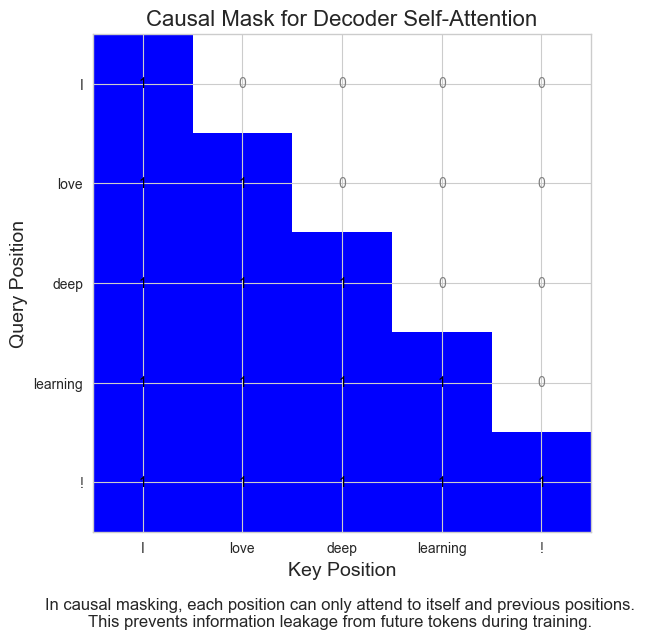

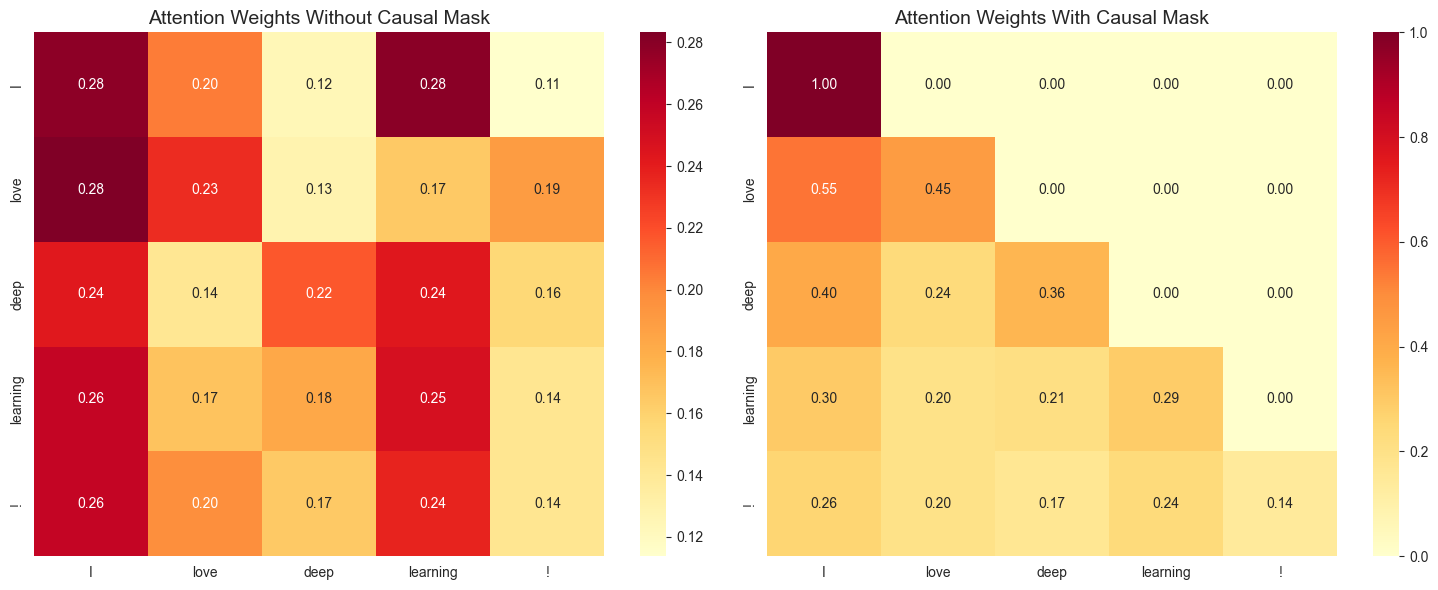

In [16]:
def generate_causal_mask(seq_len):
    """Generate a causal mask for decoder self-attention"""
    # Create a mask where each position can only attend to itself and previous positions
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    
    # Invert the mask because we want 0s where we don't attend and 1s where we do
    mask = ~mask
    
    return mask

def visualize_causal_masking():
    """Visualize causal masking in the decoder"""
    seq_len = 5
    mask = generate_causal_mask(seq_len)
    
    # Sample tokens for visualization
    tokens = ["I", "love", "deep", "learning", "!"]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Convert boolean mask to integer for better visualization
    mask_int = mask.int()
    
    # Create a custom colormap
    cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
    
    # Plot the mask
    im = ax.imshow(mask_int, cmap=cmap)
    
    # Add labels
    plt.title("Causal Mask for Decoder Self-Attention", fontsize=16)
    plt.xlabel("Key Position", fontsize=14)
    plt.ylabel("Query Position", fontsize=14)
    
    # Add text annotations
    for i in range(seq_len):
        for j in range(seq_len):
            color = "black" if mask_int[i, j] else "grey"
            ax.text(j, i, f"{mask_int[i, j].item()}", ha="center", va="center", color=color)
    
    # Add token labels
    ax.set_xticks(np.arange(seq_len))
    ax.set_yticks(np.arange(seq_len))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    
    # Add a description
    plt.figtext(0.5, -0.05, 
                "In causal masking, each position can only attend to itself and previous positions.\n"
                "This prevents information leakage from future tokens during training.",
                wrap=True, horizontalalignment='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Also visualize how this affects attention weights
    # Create sample decoder with causal masking
    d_model = 32
    num_heads = 4
    
    # Sample inputs
    x = torch.randn(1, seq_len, d_model)
    
    # Self-attention with causal mask
    self_attn = SelfAttention(d_model, num_heads)
    causal_mask = generate_causal_mask(seq_len).unsqueeze(0).unsqueeze(0)
    
    # Forward pass with and without mask
    with torch.no_grad():
        _, attn_no_mask = self_attn(x, return_attention=True)
        _, attn_with_mask = self_attn(x, mask=causal_mask, return_attention=True)
    
    # Visualize attention patterns
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Without mask
    sns.heatmap(
        attn_no_mask[0, 0].numpy(),
        ax=axes[0],
        cmap='YlOrRd',
        annot=True,
        fmt=".2f",
        xticklabels=tokens,
        yticklabels=tokens
    )
    axes[0].set_title("Attention Weights Without Causal Mask", fontsize=14)
    
    # With mask
    sns.heatmap(
        attn_with_mask[0, 0].numpy(),
        ax=axes[1],
        cmap='YlOrRd',
        annot=True,
        fmt=".2f",
        xticklabels=tokens,
        yticklabels=tokens
    )
    axes[1].set_title("Attention Weights With Causal Mask", fontsize=14)
    
    plt.tight_layout()
    plt.show()

visualize_causal_masking()

## 7. Complete Transformer Model

Now, let's assemble the full transformer model by stacking multiple encoder and decoder layers.

### 7.1 Implementation

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self, 
        src_vocab_size, 
        tgt_vocab_size, 
        d_model=512, 
        num_heads=8, 
        num_encoder_layers=6,
        num_decoder_layers=6, 
        d_ff=2048, 
        max_seq_length=100, 
        dropout=0.1
    ):
        super(Transformer, self).__init__()
        
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = get_positional_encoding(max_seq_length, d_model)
        
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_encoder_layers)
        ])
        
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_decoder_layers)
        ])
        
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        
    def generate_square_subsequent_mask(self, sz):
        """Generate a causal mask for the decoder"""
        return generate_causal_mask(sz)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Create masks if not provided
        if src_mask is None:
            src_mask = torch.ones(src.shape[0], 1, 1, src.shape[1])
            
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(tgt.shape[1])
            tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(0)
            
        # Get embeddings and add positional encoding
        src_emb = self.encoder_embedding(src) * math.sqrt(self.d_model)
        positional_encoding = self.positional_encoding[:src.shape[1], :]
        src_emb = src_emb + positional_encoding
        src_emb = self.dropout(src_emb)
        
        tgt_emb = self.decoder_embedding(tgt) * math.sqrt(self.d_model)
        positional_encoding = self.positional_encoding[:tgt.shape[1], :]
        tgt_emb = tgt_emb + positional_encoding
        tgt_emb = self.dropout(tgt_emb)
        
        # Encoder forward pass
        enc_output = src_emb
        enc_attn_weights = []
        
        for enc_layer in self.encoder_layers:
            enc_output, attn_weights = enc_layer(enc_output, src_mask, return_attention=True)
            enc_attn_weights.append(attn_weights)
            
        # Decoder forward pass
        dec_output = tgt_emb
        dec_self_attn_weights = []
        dec_cross_attn_weights = []
        
        for dec_layer in self.decoder_layers:
            dec_output, self_attn, cross_attn = dec_layer(
                dec_output, enc_output, src_mask, tgt_mask, return_attention=True
            )
            dec_self_attn_weights.append(self_attn)
            dec_cross_attn_weights.append(cross_attn)
            
        # Final linear projection
        output = self.fc_out(dec_output)
        
        return output, enc_attn_weights, dec_self_attn_weights, dec_cross_attn_weights

### 7.2 Mathematical Formulation of the Transformer Architecture

The Transformer is a sequence-to-sequence architecture based entirely on attention mechanisms, without recurrence or convolution. Its core components can be described as follows:

---

#### 1. **Input Representation**

Let $x = (x_1, x_2, \ldots, x_n)$ be a sequence of token indices. Each token is mapped to a dense vector via an embedding matrix $E \in \mathbb{R}^{V \times d_{\text{model}}}$, where $V$ is the vocabulary size.

$$
\mathbf{E}_{\text{input}} = E(x) \cdot \sqrt{d_{\text{model}}} + \mathbf{P}
$$

Here:

* $\mathbf{E}_{\text{input}} \in \mathbb{R}^{n \times d_{\text{model}}}$ is the input embedding matrix.
* $\mathbf{P} \in \mathbb{R}^{n \times d_{\text{model}}}$ is the positional encoding matrix.
* The scaling factor $\sqrt{d_{\text{model}}}$ stabilizes the variance of dot-product attention.

---

#### 2. **Scaled Dot-Product Attention**

Given queries $Q$, keys $K$, and values $V$, each of shape $\mathbb{R}^{n \times d_k}$, attention is computed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

In practice, these are obtained via learned linear projections from the input:

$$
Q = XW^Q, \quad K = XW^K, \quad V = XW^V
$$

where $W^Q, W^K, W^V \in \mathbb{R}^{d_{\text{model}} \times d_k}$.

---

#### 3. **Multi-Head Attention**

Multi-head attention allows the model to jointly attend to information from different representation subspaces:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O
$$

where each head is:

$$
\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

with output projection $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.

---

#### 4. **Feed-Forward Network (FFN)**

Each position in the sequence passes through the same two-layer feed-forward network:

$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

with learned weights $W_1 \in \mathbb{R}^{d_{\text{model}} \times d_{\text{ff}}}$, $W_2 \in \mathbb{R}^{d_{\text{ff}} \times d_{\text{model}}}$.

---

#### 5. **Encoder Layer**

An encoder layer consists of:

1. Multi-head self-attention
2. Add & LayerNorm
3. Position-wise FFN
4. Add & LayerNorm

Formally:

$$
\begin{aligned}
Z_1 &= \text{LayerNorm}(X + \text{Dropout}(\text{MultiHead}(X, X, X))) \\
Z_2 &= \text{LayerNorm}(Z_1 + \text{Dropout}(\text{FFN}(Z_1)))
\end{aligned}
$$

where $X \in \mathbb{R}^{n \times d_{\text{model}}}$ is the input to the layer.

---

#### 6. **Decoder Layer**

The decoder layer additionally includes **masked self-attention** to prevent information leakage from future tokens, and **cross-attention** to the encoder output $\mathbf{H}_{\text{enc}}$:

$$
\begin{aligned}
Z_1 &= \text{LayerNorm}(X + \text{Dropout}(\text{MaskedMultiHead}(X, X, X))) \\
Z_2 &= \text{LayerNorm}(Z_1 + \text{Dropout}(\text{MultiHead}(Z_1, H_{\text{enc}}, H_{\text{enc}}))) \\
Z_3 &= \text{LayerNorm}(Z_2 + \text{Dropout}(\text{FFN}(Z_2)))
\end{aligned}
$$

---

#### 7. **Final Output Projection**

The final decoder output $Z$ is passed through a linear projection to vocabulary dimension, followed by a softmax to compute token probabilities:

$$
\text{Output} = \text{softmax}(Z W^T + b), \quad W \in \mathbb{R}^{V \times d_{\text{model}}}
$$

This is typically implemented as **weight tying** with the input embedding matrix $E$.

English Vocabulary Size: 20
Spanish Vocabulary Size: 23
Running tokenization visualization...


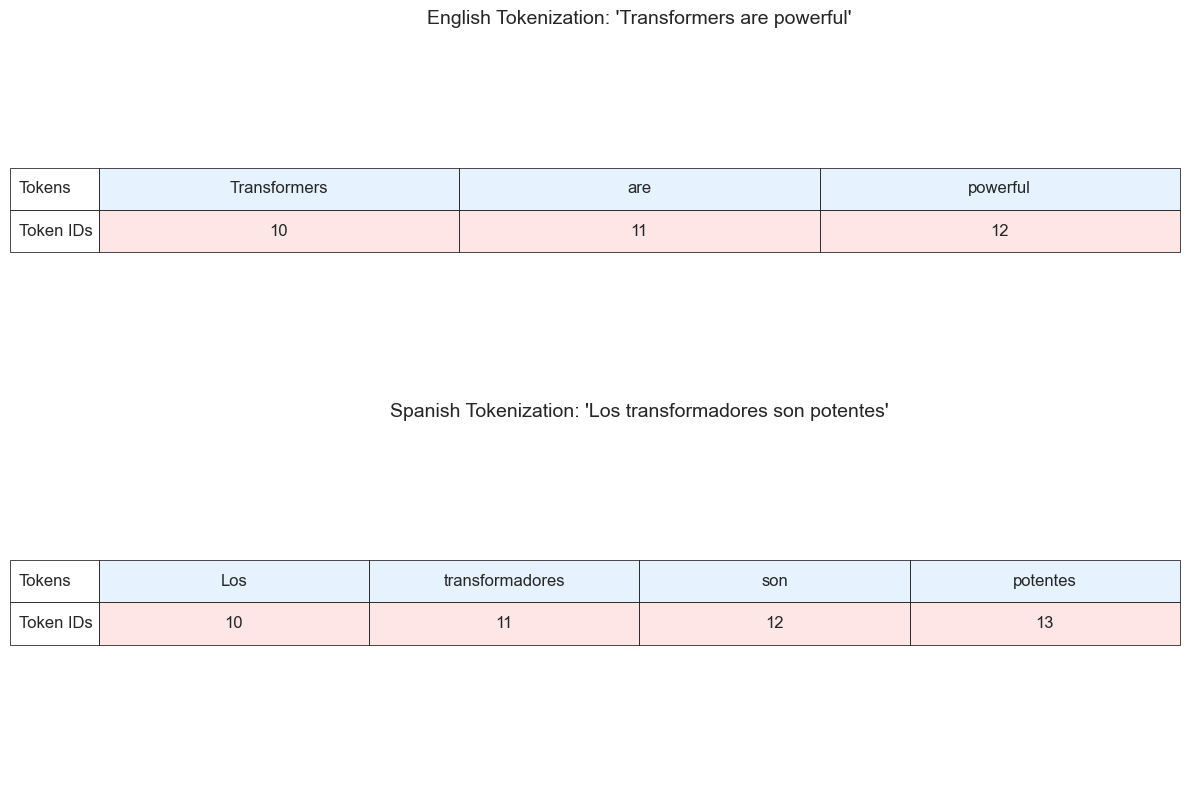

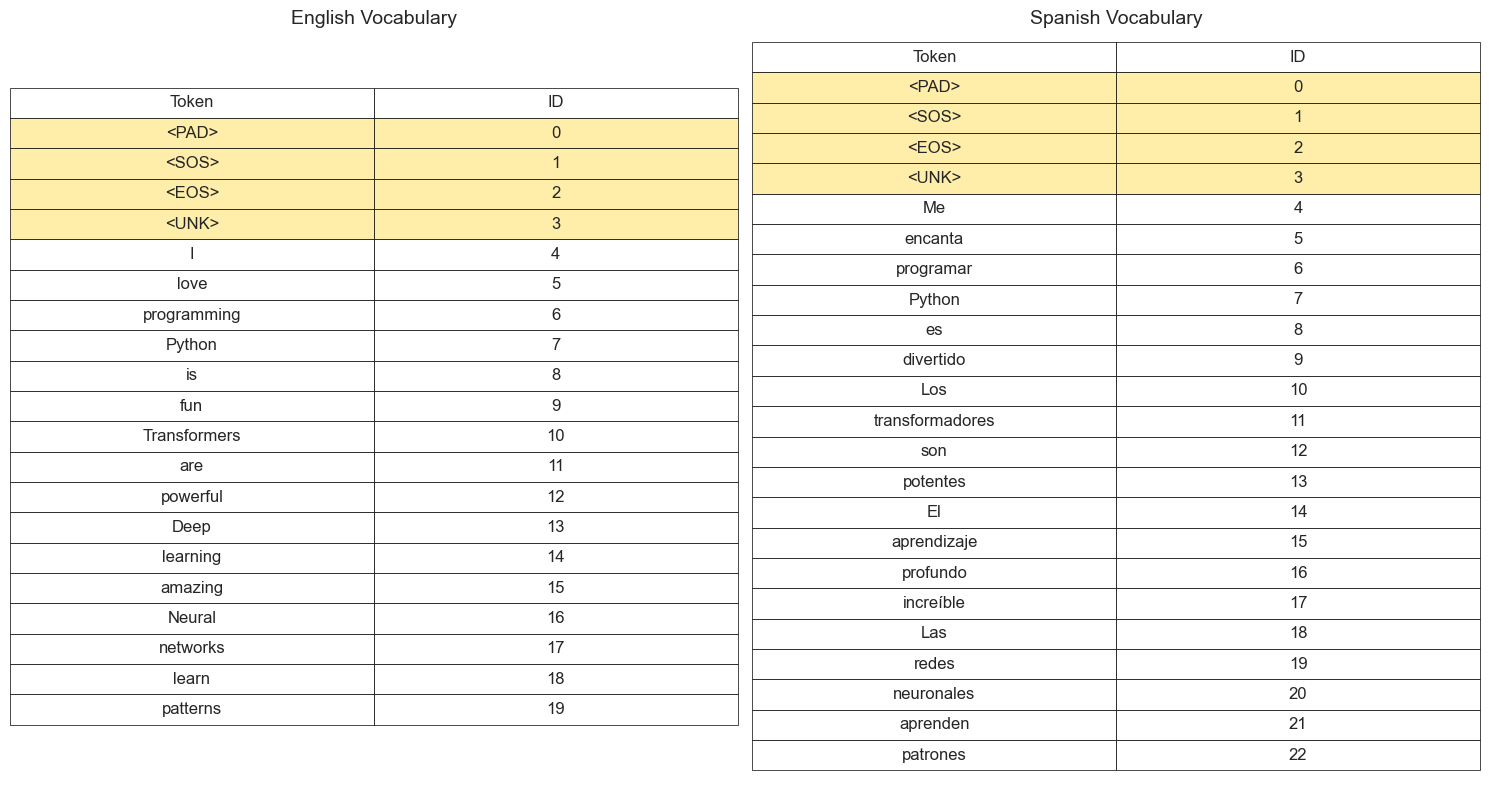


Running batch visualization...


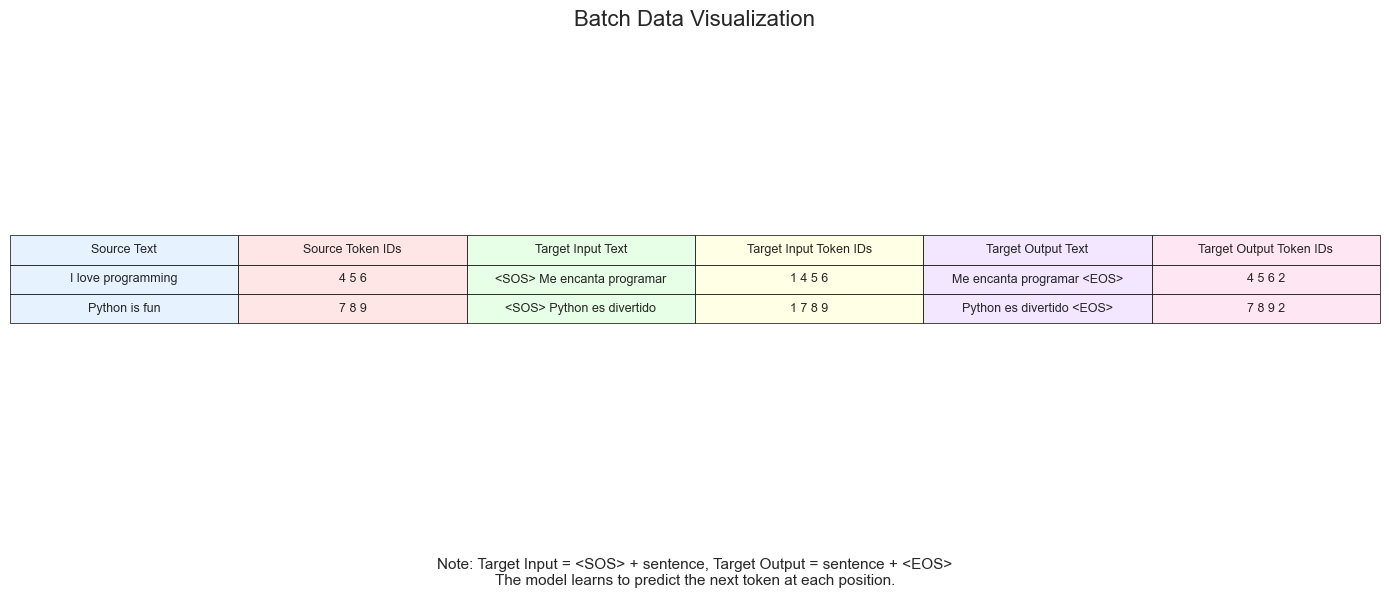


Running teacher forcing visualization...


/Users/seman/aulas_2025_1/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


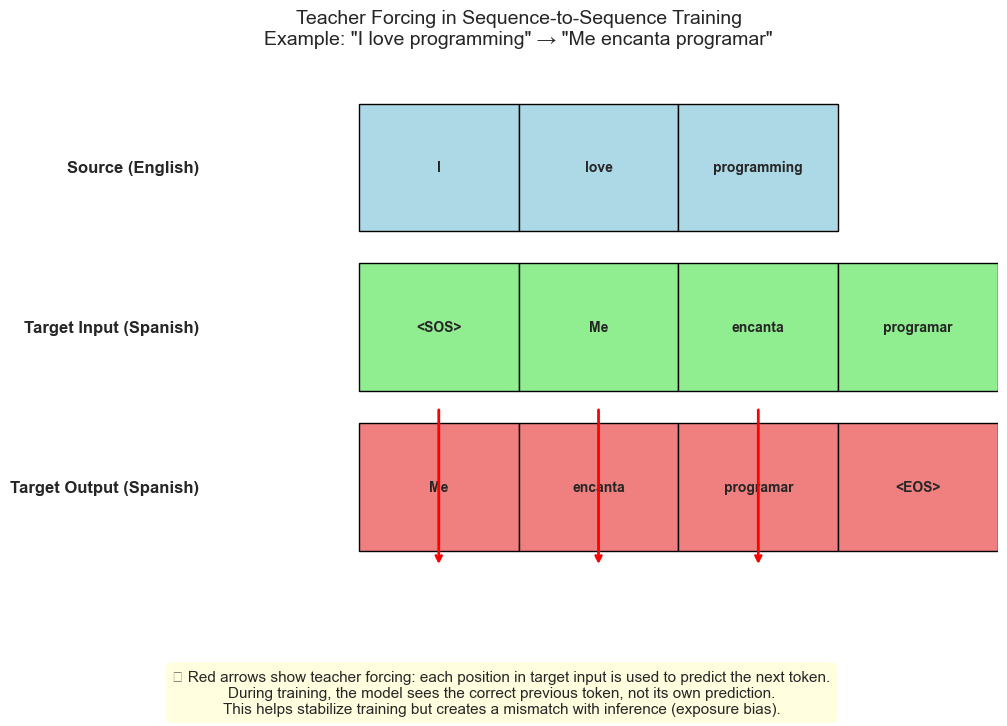


Sample encoded data:
English sentence: I love programming
Encoded: [4, 5, 6]
Spanish sentence: Me encanta programar
Encoded: [4, 5, 6]

Dataset sample:
Source: tensor([4, 5, 6])
Target input: tensor([1, 4, 5, 6])
Target output: tensor([4, 5, 6, 2])


In [18]:
# Import required libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Simple tokenizer for our toy task
class SimpleTokenizer:
    def __init__(self):
        self.token_to_idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx_to_token = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.vocab_size = 4  # Initial size with special tokens
        
    def add_token(self, token):
        if token not in self.token_to_idx:
            self.token_to_idx[token] = self.vocab_size
            self.idx_to_token[self.vocab_size] = token
            self.vocab_size += 1
    
    def build_vocab(self, sentences):
        """Build vocabulary from a list of sentences"""
        for sentence in sentences:
            tokens = sentence.split()
            for token in tokens:
                self.add_token(token)
    
    def encode(self, sentence):
        tokens = sentence.split()
        return [self.token_to_idx.get(token, self.token_to_idx["<UNK>"]) for token in tokens]
    
    def decode(self, indices):
        tokens = [self.idx_to_token.get(idx, "<UNK>") for idx in indices]
        return " ".join(tokens)

# Create toy English to Spanish translation data
english_sentences = [
    "I love programming",
    "Python is fun",
    "Transformers are powerful",
    "Deep learning is amazing",
    "Neural networks learn patterns"
]

spanish_sentences = [
    "Me encanta programar",
    "Python es divertido",
    "Los transformadores son potentes",
    "El aprendizaje profundo es increíble",
    "Las redes neuronales aprenden patrones"
]

# Create tokenizers and build vocabularies
english_tokenizer = SimpleTokenizer()
spanish_tokenizer = SimpleTokenizer()

# Build vocabularies from all sentences first
english_tokenizer.build_vocab(english_sentences)
spanish_tokenizer.build_vocab(spanish_sentences)

# Encode the sentences
english_encoded = []
for sent in english_sentences:
    english_encoded.append(english_tokenizer.encode(sent))
    
spanish_encoded = []
for sent in spanish_sentences:
    spanish_encoded.append(spanish_tokenizer.encode(sent))

print("English Vocabulary Size:", english_tokenizer.vocab_size)
print("Spanish Vocabulary Size:", spanish_tokenizer.vocab_size)

# Visualize the tokenization process
def visualize_tokenization():
    """Visualize the tokenization process"""
    # Choose an example sentence
    example_idx = 2  # "Transformers are powerful" -> "Los transformadores son potentes"
    
    eng_sent = english_sentences[example_idx]
    spa_sent = spanish_sentences[example_idx]
    
    eng_tokens = eng_sent.split()
    spa_tokens = spa_sent.split()
    
    eng_ids = english_encoded[example_idx]
    spa_ids = spanish_encoded[example_idx]
    
    # Create the visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # English tokenization
    axes[0].set_title(f"English Tokenization: '{eng_sent}'", fontsize=14)
    
    # Create a table-like structure
    cell_text = []
    cell_text.append(eng_tokens)
    cell_text.append([str(idx) for idx in eng_ids])
    
    axes[0].axis('tight')
    axes[0].axis('off')
    
    table = axes[0].table(
        cellText=cell_text,
        rowLabels=['Tokens', 'Token IDs'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Color the cells
    for i in range(len(eng_tokens)):
        table[(0, i)].set_facecolor('#E6F3FF')
        table[(1, i)].set_facecolor('#FFE6E6')
    
    # Spanish tokenization
    axes[1].set_title(f"Spanish Tokenization: '{spa_sent}'", fontsize=14)
    
    # Create a table-like structure
    cell_text = []
    cell_text.append(spa_tokens)
    cell_text.append([str(idx) for idx in spa_ids])
    
    axes[1].axis('tight')
    axes[1].axis('off')
    
    table = axes[1].table(
        cellText=cell_text,
        rowLabels=['Tokens', 'Token IDs'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Color the cells
    for i in range(len(spa_tokens)):
        table[(0, i)].set_facecolor('#E6F3FF')
        table[(1, i)].set_facecolor('#FFE6E6')
    
    plt.tight_layout()
    plt.show()
    
    # Also show the vocabulary
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    
    # English vocabulary
    eng_vocab = sorted(english_tokenizer.token_to_idx.items(), key=lambda x: x[1])
    eng_tokens_vocab, eng_ids_vocab = zip(*eng_vocab)
    
    axes[0].set_title("English Vocabulary", fontsize=14)
    
    # Create a table
    eng_table_data = [[token, str(id)] for token, id in zip(eng_tokens_vocab, eng_ids_vocab)]
    
    axes[0].axis('tight')
    axes[0].axis('off')
    
    table = axes[0].table(
        cellText=eng_table_data,
        colLabels=['Token', 'ID'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    # Color special tokens
    for i in range(4):  # First 4 are special tokens
        table[(i+1, 0)].set_facecolor('#FFEEAA')
        table[(i+1, 1)].set_facecolor('#FFEEAA')
    
    # Spanish vocabulary
    spa_vocab = sorted(spanish_tokenizer.token_to_idx.items(), key=lambda x: x[1])
    spa_tokens_vocab, spa_ids_vocab = zip(*spa_vocab)
    
    axes[1].set_title("Spanish Vocabulary", fontsize=14)
    
    # Create a table
    spa_table_data = [[token, str(id)] for token, id in zip(spa_tokens_vocab, spa_ids_vocab)]
    
    axes[1].axis('tight')
    axes[1].axis('off')
    
    table = axes[1].table(
        cellText=spa_table_data,
        colLabels=['Token', 'ID'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    # Color special tokens
    for i in range(4):  # First 4 are special tokens
        table[(i+1, 0)].set_facecolor('#FFEEAA')
        table[(i+1, 1)].set_facecolor('#FFEEAA')
    
    plt.tight_layout()
    plt.show()

# Create a custom dataset
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_tokenizer, tgt_tokenizer):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        src_sent = self.src_sentences[idx]
        tgt_sent = self.tgt_sentences[idx]
        
        src_encoded = self.src_tokenizer.encode(src_sent)
        tgt_encoded = [self.tgt_tokenizer.token_to_idx["<SOS>"]] + \
                    self.tgt_tokenizer.encode(tgt_sent) + \
                    [self.tgt_tokenizer.token_to_idx["<EOS>"]]
        
        return {
            "src": torch.tensor(src_encoded, dtype=torch.long),
            "tgt": torch.tensor(tgt_encoded[:-1], dtype=torch.long),  # Input to the decoder (without EOS)
            "tgt_y": torch.tensor(tgt_encoded[1:], dtype=torch.long)  # Target output (without SOS)
        }

# Create the dataset
dataset = TranslationDataset(
    english_sentences, spanish_sentences, 
    english_tokenizer, spanish_tokenizer
)

# Function to create batches (with padding)
def collate_fn(batch):
    src_batch = [item["src"] for item in batch]
    tgt_batch = [item["tgt"] for item in batch]
    tgt_y_batch = [item["tgt_y"] for item in batch]
    
    # Pad sequences
    src_batch = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    tgt_y_batch = nn.utils.rnn.pad_sequence(tgt_y_batch, batch_first=True, padding_value=0)
    
    return {
        "src": src_batch,
        "tgt": tgt_batch,
        "tgt_y": tgt_y_batch
    }

# Create data loader
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)

# Visualize a batch
def visualize_batch():
    """Visualize a batch from the dataloader"""
    # Get a batch
    batch = next(iter(dataloader))
    
    src = batch["src"]
    tgt = batch["tgt"]
    tgt_y = batch["tgt_y"]
    
    # Function to decode indices
    def decode_batch(batch_tensor, tokenizer):
        decoded = []
        for seq in batch_tensor:
            # Remove padding tokens
            seq = seq[seq != 0].tolist()
            decoded.append(tokenizer.decode(seq))
        return decoded
    
    # Decode the batch
    src_decoded = decode_batch(src, english_tokenizer)
    tgt_decoded = decode_batch(tgt, spanish_tokenizer)
    tgt_y_decoded = decode_batch(tgt_y, spanish_tokenizer)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create table data
    table_data = []
    
    for i in range(len(src_decoded)):
        # Source sequence
        src_seq = src[i].tolist()
        src_seq = [str(idx) for idx in src_seq if idx != 0]  # Remove padding
        
        # Target input sequence
        tgt_seq = tgt[i].tolist()
        tgt_seq = [str(idx) for idx in tgt_seq if idx != 0]  # Remove padding
        
        # Target output sequence
        tgt_y_seq = tgt_y[i].tolist()
        tgt_y_seq = [str(idx) for idx in tgt_y_seq if idx != 0]  # Remove padding
        
        # Add to table
        table_data.append([
            src_decoded[i],
            " ".join(src_seq),
            tgt_decoded[i],
            " ".join(tgt_seq),
            tgt_y_decoded[i],
            " ".join(tgt_y_seq)
        ])
    
    # Create table
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(
        cellText=table_data,
        colLabels=[
            "Source Text", 
            "Source Token IDs", 
            "Target Input Text", 
            "Target Input Token IDs",
            "Target Output Text",
            "Target Output Token IDs"
        ],
        loc='center',
        cellLoc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Color the columns
    colors = ['#E6F3FF', '#FFE6E6', '#E6FFE6', '#FFFFE6', '#F3E6FF', '#FFE6F3']
    for i in range(len(colors)):
        table[(0, i)].set_facecolor(colors[i])
        for j in range(1, len(table_data) + 1):
            table[(j, i)].set_facecolor(colors[i])
    
    plt.title("Batch Data Visualization", fontsize=16, pad=20)
    plt.figtext(0.5, 0.02, 
                "Note: Target Input = <SOS> + sentence, Target Output = sentence + <EOS>\n"
                "The model learns to predict the next token at each position.",
                wrap=True, horizontalalignment='center', fontsize=11)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# Visualize teacher forcing mechanism
def visualize_teacher_forcing():
    """Visualize the teacher forcing mechanism"""
    # Get a sample
    sample = dataset[0]  # First sample
    
    src_text = english_sentences[0]
    tgt_text = spanish_sentences[0]
    
    # Get the actual tensors
    src_ids = sample["src"].tolist()
    tgt_ids = sample["tgt"].tolist()
    tgt_y_ids = sample["tgt_y"].tolist()
    
    # Decode for display
    src_tokens = src_text.split()
    tgt_input_tokens = ["<SOS>"] + tgt_text.split()
    tgt_output_tokens = tgt_text.split() + ["<EOS>"]
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    max_len = max(len(src_tokens), len(tgt_input_tokens), len(tgt_output_tokens))
    
    # Create a grid to show the sequences
    y_positions = [2, 1, 0]
    labels = ['Source (English)', 'Target Input (Spanish)', 'Target Output (Spanish)']
    token_lists = [src_tokens, tgt_input_tokens, tgt_output_tokens]
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    
    for i, (y_pos, label, tokens, color) in enumerate(zip(y_positions, labels, token_lists, colors)):
        # Draw boxes for tokens
        for j, token in enumerate(tokens):
            rect = plt.Rectangle((j, y_pos), 1, 0.8, 
                               facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            ax.text(j + 0.5, y_pos + 0.4, token, 
                   ha='center', va='center', fontsize=10, weight='bold')
        
        # Add label
        ax.text(-1, y_pos + 0.4, label, ha='right', va='center', 
               fontsize=12, weight='bold')
    
    # Add arrows to show teacher forcing
    for j in range(len(tgt_input_tokens) - 1):
        # Arrow from target input to target output
        ax.annotate('', xy=(j + 0.5, -0.1), xytext=(j + 0.5, 0.9),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    # Set limits and remove axes
    ax.set_xlim(-2, max_len)
    ax.set_ylim(-0.5, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title('Teacher Forcing in Sequence-to-Sequence Training\n' +
             f'Example: "{src_text}" → "{tgt_text}"', 
             fontsize=14, pad=20)
    
    # Add explanation
    plt.figtext(0.5, 0.15, 
                "🔴 Red arrows show teacher forcing: each position in target input is used to predict the next token.\n"
                "During training, the model sees the correct previous token, not its own prediction.\n"
                "This helps stabilize training but creates a mismatch with inference (exposure bias).",
                wrap=True, horizontalalignment='center', fontsize=11,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow"))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

# Run visualizations
if __name__ == "__main__":
    print("Running tokenization visualization...")
    visualize_tokenization()
    
    print("\nRunning batch visualization...")
    visualize_batch()
    
    print("\nRunning teacher forcing visualization...")
    visualize_teacher_forcing()
    
    # Print some sample data
    print(f"\nSample encoded data:")
    print(f"English sentence: {english_sentences[0]}")
    print(f"Encoded: {english_encoded[0]}")
    print(f"Spanish sentence: {spanish_sentences[0]}")
    print(f"Encoded: {spanish_encoded[0]}")
    
    sample = dataset[0]
    print(f"\nDataset sample:")
    print(f"Source: {sample['src']}")
    print(f"Target input: {sample['tgt']}")
    print(f"Target output: {sample['tgt_y']}")

### 8.2 Training the Transformer

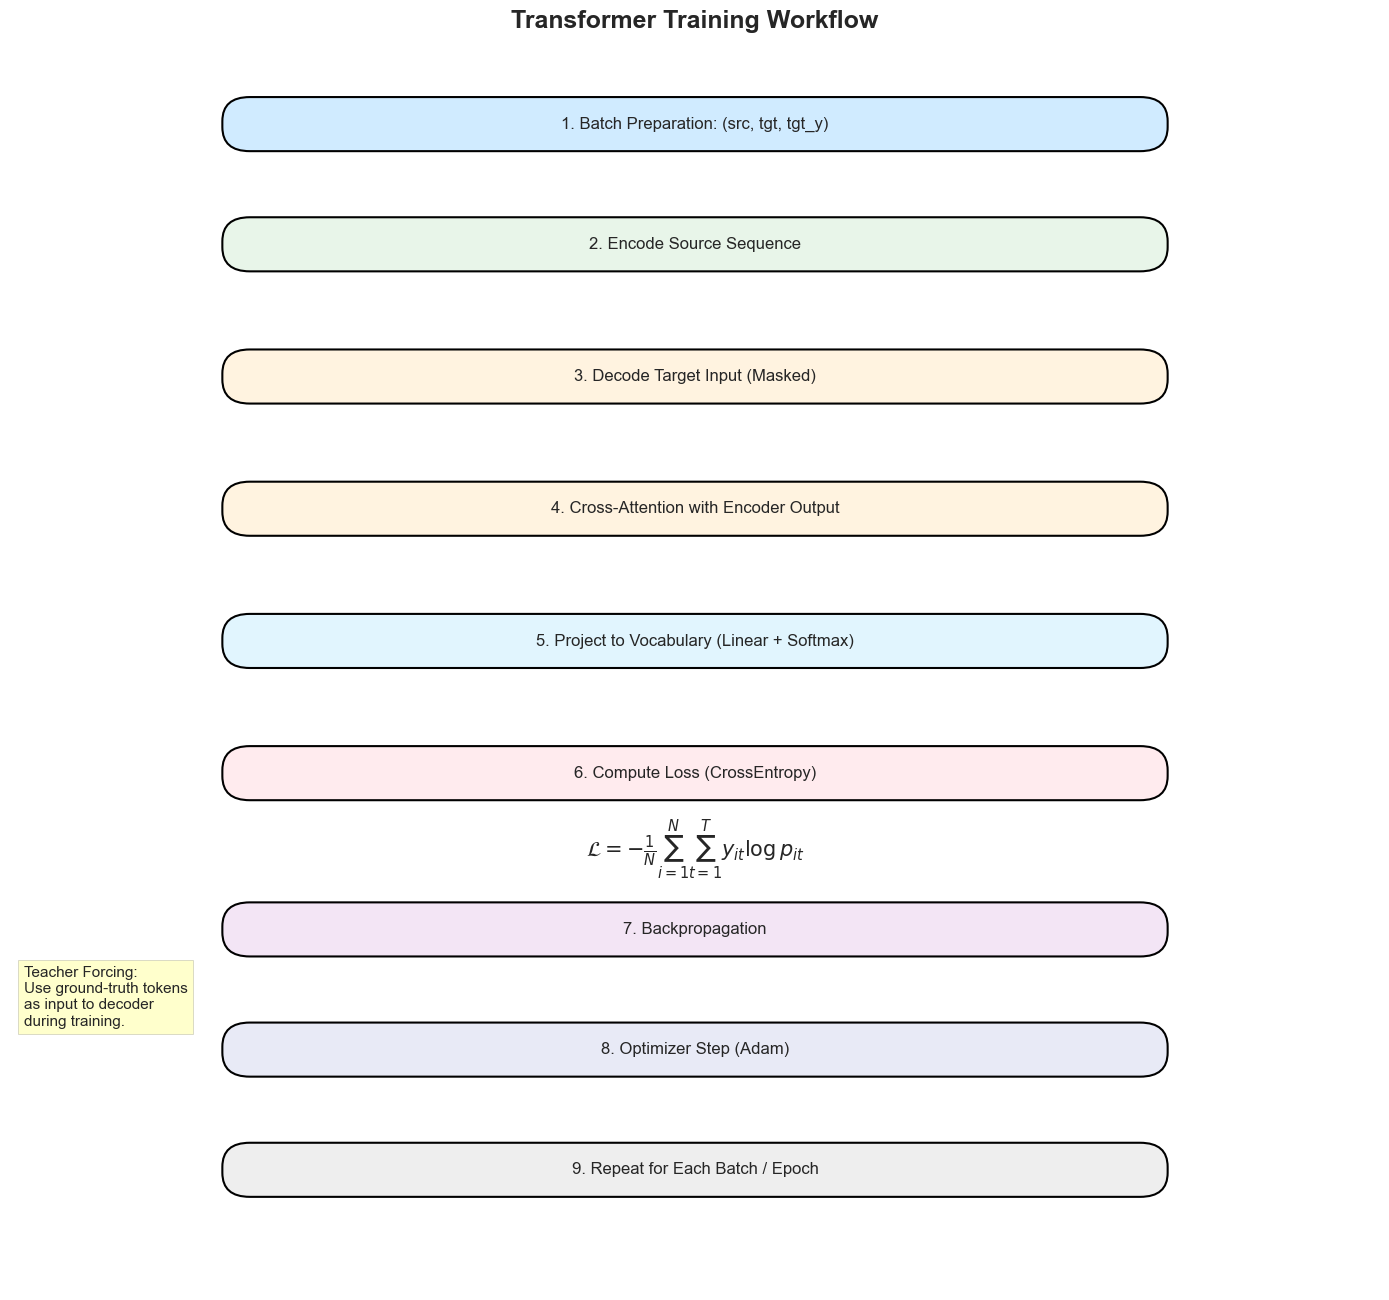

In [19]:
def visualize_training_process_fixed():
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(figsize=(14, 13))
    ax.set_axis_off()

    def draw_box(center_x, center_y, text, width=0.65, height=0.005, color='lightgray', fontsize=12, lw=1.5):
        rect = patches.FancyBboxPatch(
            (center_x - width / 2, center_y - height / 2),
            width, height,
            boxstyle="round,pad=0.02",
            edgecolor='black',
            facecolor=color,
            linewidth=lw
        )
        ax.add_patch(rect)
        ax.text(center_x, center_y, text, ha='center', va='center', fontsize=fontsize)

    def draw_arrow(from_x, from_y, to_y):
        ax.annotate("", xy=(from_x, to_y), xytext=(from_x, from_y),
                    arrowprops=dict(arrowstyle="->", lw=1.5))

    # Title
    ax.text(0.5, 1.05, "Transformer Training Workflow", fontsize=18, ha='center', weight='bold')

    # Sequence of steps with corrected spacing
    y_levels = [
        0.97,  # 1. Batch
        0.87,  # 2. Encode
        0.76,  # 3. Decode
        0.65,  # 4. Cross Attention
        0.54,  # 5. Linear + Softmax
        0.43,  # 6. Loss
        0.30,  # 7. Backward
        0.20,  # 8. Optimizer
        0.10   # 9. Repeat
    ]

    steps = [
        ("1. Batch Preparation: (src, tgt, tgt_y)", '#D0EBFF'),
        ("2. Encode Source Sequence", '#E8F5E9'),
        ("3. Decode Target Input (Masked)", '#FFF3E0'),
        ("4. Cross-Attention with Encoder Output", '#FFF3E0'),
        ("5. Project to Vocabulary (Linear + Softmax)", '#E1F5FE'),
        ("6. Compute Loss (CrossEntropy)", '#FFEBEE'),
        ("7. Backpropagation", '#F3E5F5'),
        ("8. Optimizer Step (Adam)", '#E8EAF6'),
        ("9. Repeat for Each Batch / Epoch", '#EEEEEE')
    ]

    # Draw all boxes and arrows
    for i, ((label, color), y) in enumerate(zip(steps, y_levels)):
        draw_box(0.5, y, label, color=color)
        if i < len(y_levels) - 1:
            draw_arrow(0.5, y - 0.04, y_levels[i + 1] + 0.04)

    # Draw loss formula
    ax.text(0.5, 0.36,
            r"$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{t=1}^{T} y_{it} \log p_{it}$",
            fontsize=15, ha='center', bbox=dict(facecolor='white', alpha=0.7))

    # Draw teacher forcing box
    ax.text(0.01, 0.22,
            "Teacher Forcing:\nUse ground-truth tokens\nas input to decoder\nduring training.",
            fontsize=11, ha='left', bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.2))

    plt.tight_layout()
    plt.show()

visualize_training_process_fixed()

Epoch 1/10, Loss: 3.1568
Epoch 2/10, Loss: 2.7072
Epoch 3/10, Loss: 2.3258
Epoch 4/10, Loss: 2.1077
Epoch 5/10, Loss: 1.7897
Epoch 6/10, Loss: 1.5303
Epoch 7/10, Loss: 1.4068
Epoch 8/10, Loss: 1.2025
Epoch 9/10, Loss: 1.0754
Epoch 10/10, Loss: 0.9304


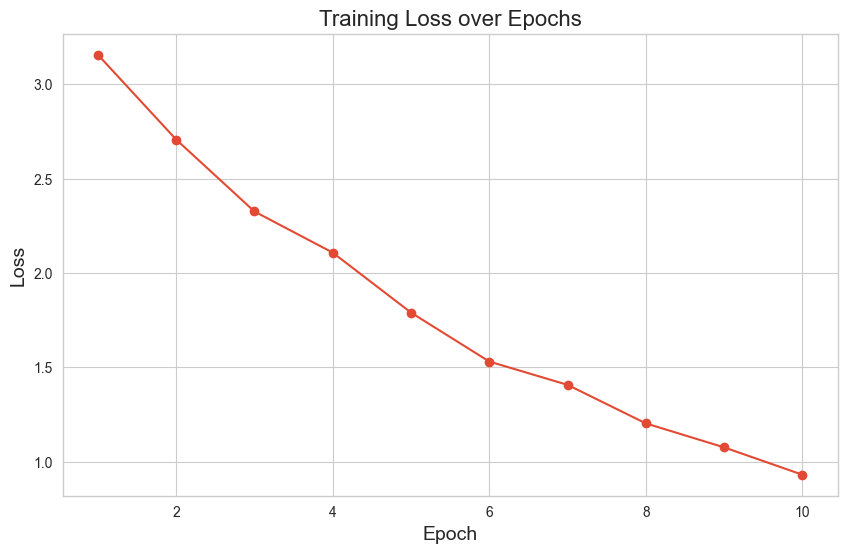

In [20]:
# Initialize model
transformer = Transformer(
    src_vocab_size=english_tokenizer.vocab_size,
    tgt_vocab_size=spanish_tokenizer.vocab_size,
    d_model=64,  # Smaller model for demonstration
    num_heads=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    d_ff=128,
    max_seq_length=50,
    dropout=0.1
)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)


# Training function
def train_epoch(model, dataloader, criterion, optimizer):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        src = batch["src"]
        tgt = batch["tgt"]
        tgt_y = batch["tgt_y"]
        
        # Forward pass
        output, *_ = model(src, tgt)
        
        # Reshape output and target for loss calculation
        output = output.reshape(-1, output.size(-1))
        tgt_y = tgt_y.reshape(-1)
        
        # Calculate loss
        loss = criterion(output, tgt_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Track training loss
losses = []

# Training loop (only a few epochs for demonstration)
num_epochs = 10
for epoch in range(num_epochs):
    loss = train_epoch(transformer, dataloader, criterion, optimizer)
    losses.append(loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.title("Training Loss over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.show()

### 8.3 Making Predictions with the Trained Transformer

In [21]:
def translate(model, sentence, src_tokenizer, tgt_tokenizer, max_length=50, device='cpu'):
    """
    Translate a source sentence using an autoregressive Transformer decoder.

    Args:
        model: Trained Transformer model.
        sentence (str): Source sentence to translate.
        src_tokenizer (SimpleTokenizer): Tokenizer for source language.
        tgt_tokenizer (SimpleTokenizer): Tokenizer for target language.
        max_length (int): Maximum target sequence length.
        device (str): Computation device (e.g., "cpu" or "cuda").
        
    Returns:
        translated_text (str): Decoded target sentence.
        enc_attns, dec_self_attns, dec_cross_attns: Attention weights for visualization.
    """
    model.eval()
    
    # Tokenize and convert to tensor
    src_indices = src_tokenizer.encode(sentence)
    src_tensor = torch.tensor([src_indices], dtype=torch.long, device=device)
    
    # Initialize target sequence with <SOS>
    tgt_tensor = torch.tensor([[tgt_tokenizer.token_to_idx["<SOS>"]]], device=device)

    # Store attention weights
    stored_enc_attns = None
    stored_dec_self_attns = []
    stored_dec_cross_attns = []

    for _ in range(max_length - 1):
        with torch.no_grad():
            output, enc_attns, dec_self_attns, dec_cross_attns = model(src_tensor, tgt_tensor)

        if stored_enc_attns is None:
            stored_enc_attns = enc_attns  # Only store encoder attention once

        stored_dec_self_attns.append(dec_self_attns)
        stored_dec_cross_attns.append(dec_cross_attns)

        # Select the most probable next token
        next_token = output[:, -1, :].argmax(dim=-1, keepdim=True)  # shape: (1, 1)
        tgt_tensor = torch.cat([tgt_tensor, next_token], dim=1)

        # Early stopping if <EOS> is generated
        if next_token.item() == tgt_tokenizer.token_to_idx["<EOS>"]:
            break

    # Convert back to tokens
    decoded_ids = tgt_tensor.squeeze().tolist()
    if isinstance(decoded_ids, int):
        decoded_ids = [decoded_ids]

    # Remove <SOS> and truncate at <EOS>
    if tgt_tokenizer.token_to_idx["<EOS>"] in decoded_ids:
        eos_index = decoded_ids.index(tgt_tokenizer.token_to_idx["<EOS>"])
        decoded_ids = decoded_ids[1:eos_index]
    else:
        decoded_ids = decoded_ids[1:]

    translated_text = tgt_tokenizer.decode(decoded_ids)

    return translated_text, stored_enc_attns, stored_dec_self_attns, stored_dec_cross_attns

print("Translation Examples:")
for sentence in english_sentences[:3]:
    translation, *_ = translate(transformer, sentence, english_tokenizer, spanish_tokenizer)
    print(f"English: {sentence}")
    print(f"Predicted Spanish: {translation}\n")


Translation Examples:
English: I love programming
Predicted Spanish: Me encanta programar

English: Python is fun
Predicted Spanish: Python es divertido

English: Transformers are powerful
Predicted Spanish: Los transformadores son potentes



### 8.4 Visualizing Attention in the Transformer

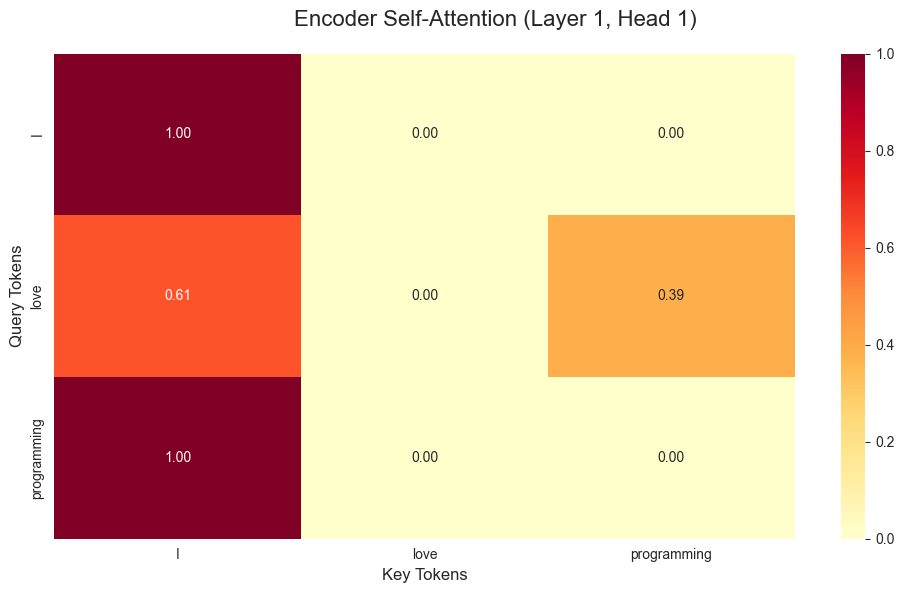

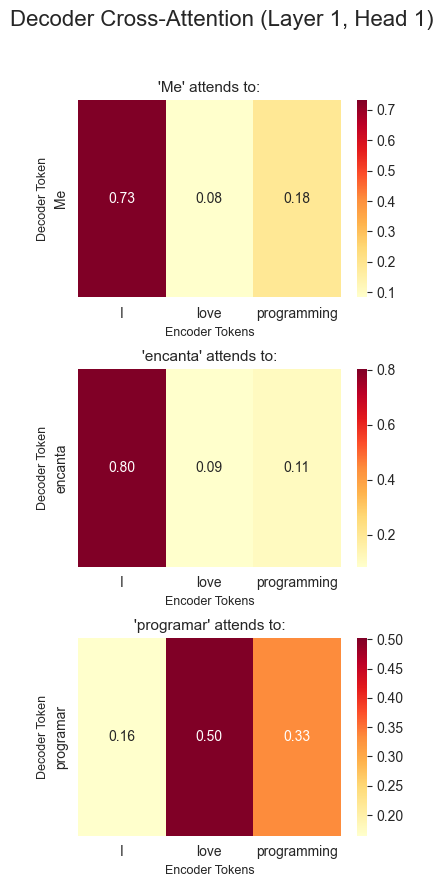

In [22]:
def visualize_translation_attention(sentence_idx=0):
    """Visualize encoder self-attention and decoder cross-attention for a sample translation."""
    # Get a sentence pair
    src_sentence = english_sentences[sentence_idx]
    tgt_sentence = spanish_sentences[sentence_idx]

    # Translate and capture attention
    translation, enc_attns, dec_self_attns, dec_cross_attns = translate(
        transformer, src_sentence, english_tokenizer, spanish_tokenizer
    )

    src_tokens = src_sentence.split()
    tgt_tokens = translation.split()

    # --- Encoder Self-Attention ---
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Encoder Self-Attention (Layer 1, Head 1)", fontsize=16)

    try:
        attn_enc = enc_attns[0][0, 0].cpu().numpy()  # [batch, head, seq, seq]
        sns.heatmap(attn_enc, xticklabels=src_tokens, yticklabels=src_tokens, annot=True, fmt=".2f", ax=ax, cmap="YlOrRd")
        ax.set_xlabel("Key Tokens", fontsize=12)
        ax.set_ylabel("Query Tokens", fontsize=12)
    except Exception as e:
        ax.text(0.5, 0.5, f"Failed to display encoder attention: {e}", ha='center')
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # --- Cross-Attention: Decoder to Encoder ---
    num_tokens = len(tgt_tokens)
    fig_rows = min(3, num_tokens)
    fig_cols = int(np.ceil(num_tokens / fig_rows))

    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(4 * fig_cols, 3 * fig_rows))
    axes = np.array(axes).reshape(-1)  # Flatten in case of 1D

    fig.suptitle("Decoder Cross-Attention (Layer 1, Head 1)", fontsize=16)

    for i in range(num_tokens):
        ax = axes[i]
        try:
            # Use attention from the i-th step (decoder timestep), first head
            attn_cross = dec_cross_attns[i][0][0, 0].cpu().numpy()  # [tgt_len, src_len]
            current_token = tgt_tokens[i] if i < len(tgt_tokens) else f"#{i}"

            sns.heatmap(
                attn_cross[-1:, :],  # Focus on last token's attention
                xticklabels=src_tokens,
                yticklabels=[current_token],
                cmap="YlOrRd",
                annot=True,
                fmt=".2f",
                ax=ax
            )
            ax.set_title(f"'{current_token}' attends to:", fontsize=11)
            ax.set_xlabel("Encoder Tokens", fontsize=9)
            ax.set_ylabel("Decoder Token", fontsize=9)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {e}", ha='center')
            ax.axis("off")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

visualize_translation_attention(sentence_idx=0)

## 9. From Transformers to Modern Language Models

### 9.1 Scaling Up: BERT, GPT, and Beyond

The transformer architecture we've explored is the foundation for modern language models. Let's examine how this architecture has evolved:

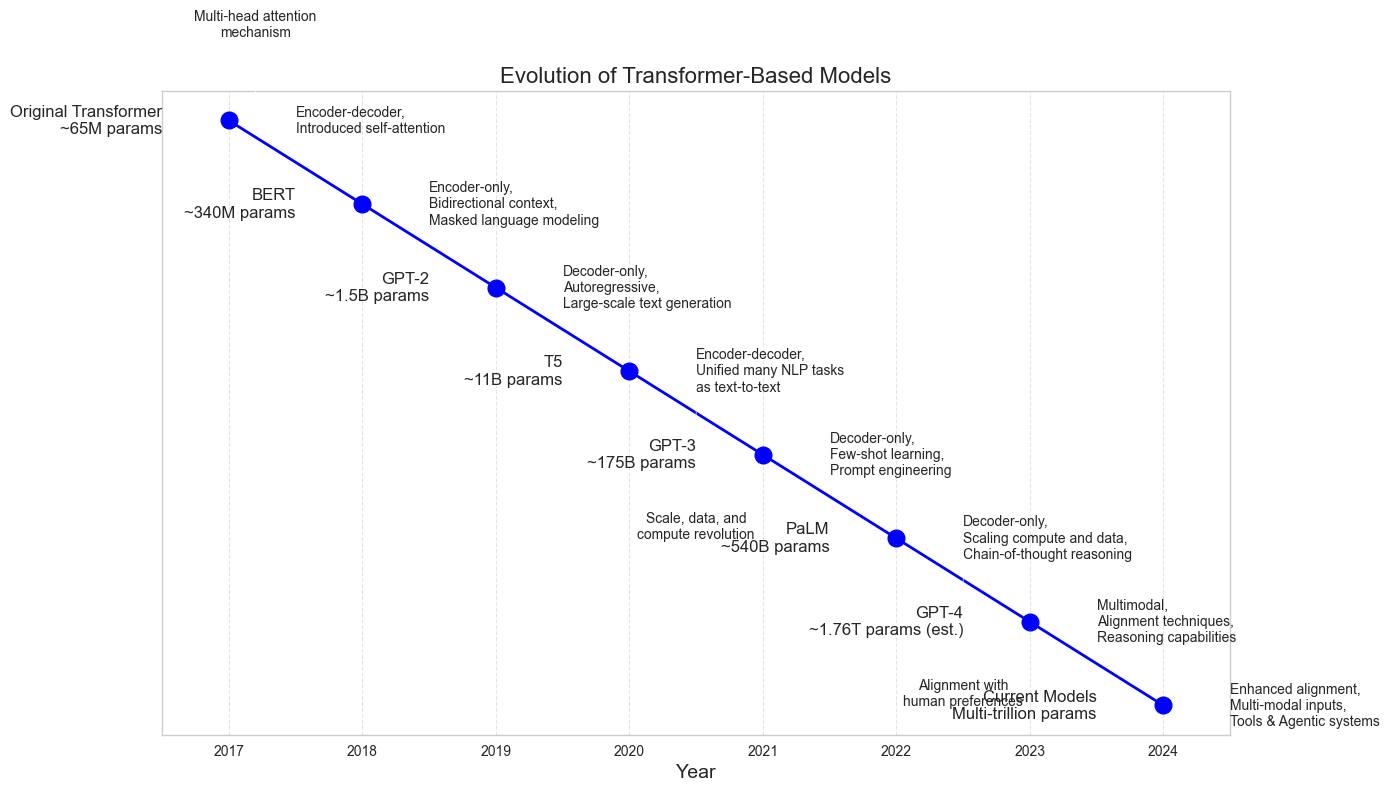

In [23]:
def visualize_transformer_evolution():
    """Visualize the evolution of transformer models"""
    # Create a timeline figure
    plt.figure(figsize=(14, 8))
    
    # Define the milestones
    years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    models = [
        "Original Transformer",
        "BERT",
        "GPT-2",
        "T5",
        "GPT-3",
        "PaLM",
        "GPT-4",
        "Current Models"
    ]
    
    sizes = [
        "~65M params",
        "~340M params",
        "~1.5B params",
        "~11B params",
        "~175B params",
        "~540B params",
        "~1.76T params (est.)",
        "Multi-trillion params"
    ]
    
    descriptions = [
        "Encoder-decoder,\nIntroduced self-attention",
        "Encoder-only,\nBidirectional context,\nMasked language modeling",
        "Decoder-only,\nAutoregressive,\nLarge-scale text generation",
        "Encoder-decoder,\nUnified many NLP tasks\nas text-to-text",
        "Decoder-only,\nFew-shot learning,\nPrompt engineering",
        "Decoder-only,\nScaling compute and data,\nChain-of-thought reasoning",
        "Multimodal,\nAlignment techniques,\nReasoning capabilities",
        "Enhanced alignment,\nMulti-modal inputs,\nTools & Agentic systems"
    ]
    
    # Plot the timeline
    for i, (year, model, size, desc) in enumerate(zip(years, models, sizes, descriptions)):
        # Calculate position
        y_pos = len(years) - 1 - i
        
        # Add year marker
        plt.plot([year], [y_pos], 'o', markersize=12, color='blue')
        
        # Add model name
        plt.text(year - 0.5, y_pos, f"{model}\n{size}", fontsize=12, ha='right', va='center')
        
        # Add description
        plt.text(year + 0.5, y_pos, desc, fontsize=10, ha='left', va='center')
        
        # Connect with line
        if i < len(years) - 1:
            plt.plot([year, years[i+1]], [y_pos, y_pos - 1], 'b-', linewidth=2)
    
    # Set axis properties
    plt.title("Evolution of Transformer-Based Models", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.yticks([])  # Hide y-axis ticks
    
    # Set x-axis limits
    plt.xlim(2016.5, 2024.5)
    plt.xticks(years)
    
    # Grid for year lines
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Add annotations for key innovations
    plt.annotate("Multi-head attention\nmechanism", xy=(2017.2, 7.2), xytext=(2017.2, 8),
                 arrowprops=dict(arrowstyle="->"), fontsize=10, ha='center')
    
    plt.annotate("Scale, data, and\ncompute revolution", xy=(2020.5, 4), xytext=(2020.5, 2),
                 arrowprops=dict(arrowstyle="->"), fontsize=10, ha='center')
    
    plt.annotate("Alignment with\nhuman preferences", xy=(2022.5, 2), xytext=(2022.5, 0),
                 arrowprops=dict(arrowstyle="->"), fontsize=10, ha='center')
    
    plt.tight_layout()
    plt.show()

visualize_transformer_evolution()

### 9.2 Different Transformer Variants

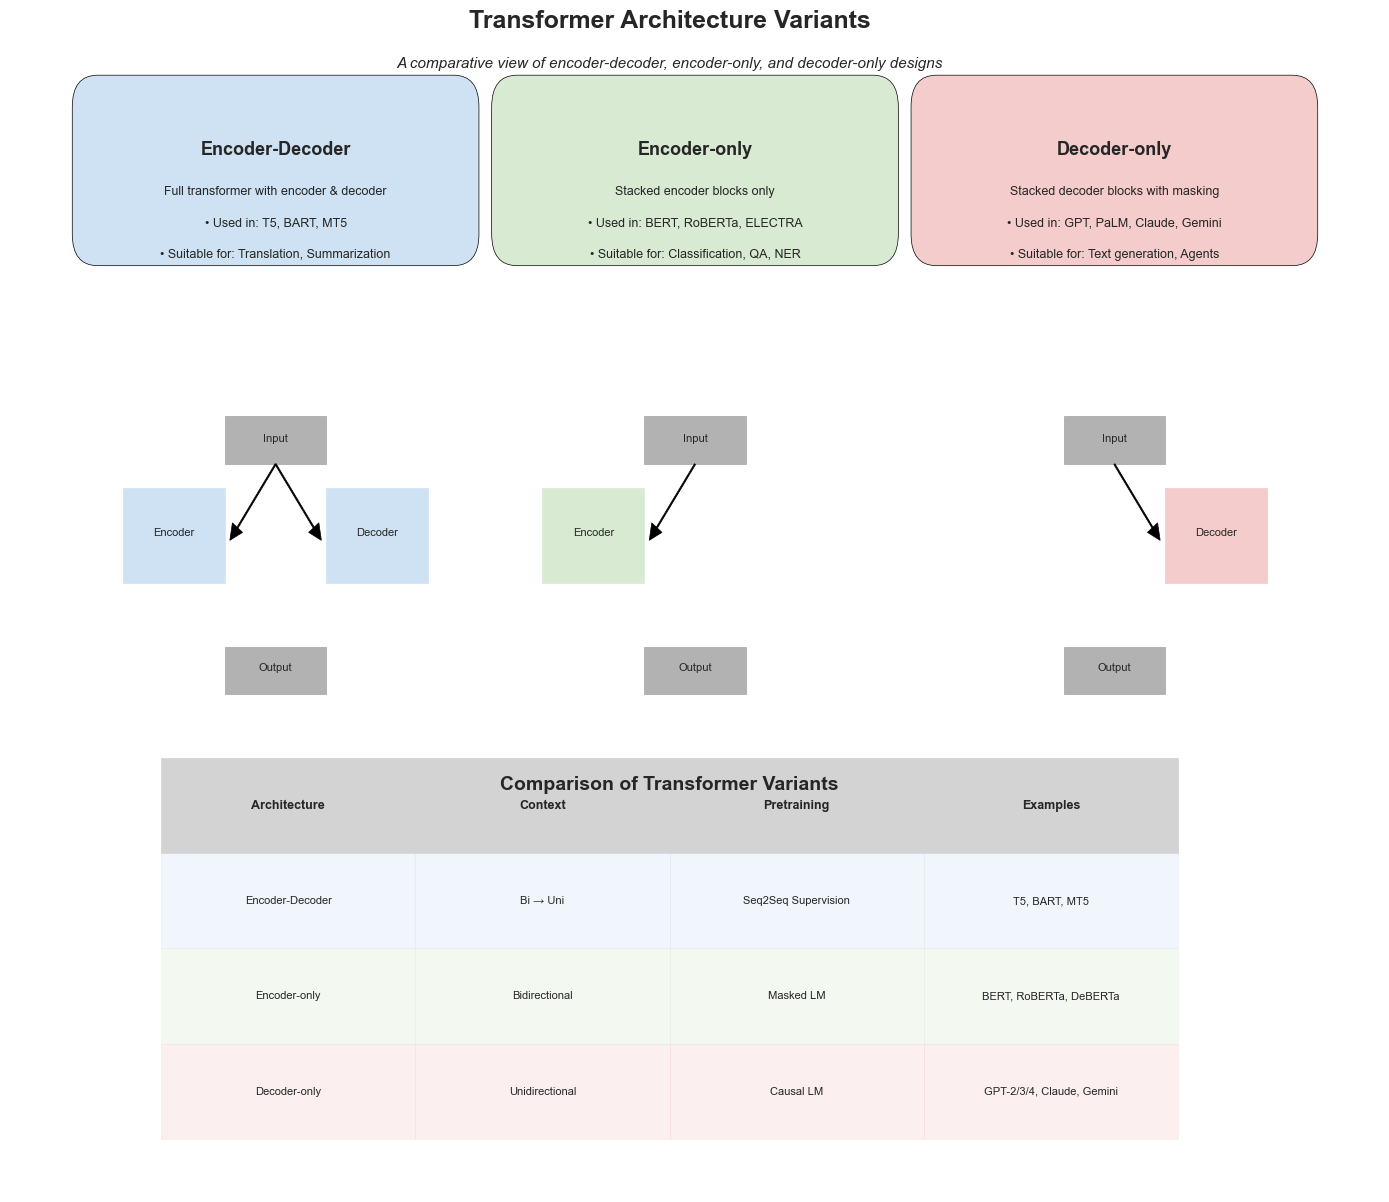

In [24]:
def visualize_transformer_variants_enhanced():
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(figsize=(14, 12))
    ax.set_axis_off()
    
    # === TITLE ===
    ax.text(0.5, 0.96, "Transformer Architecture Variants", fontsize=18, ha='center', weight='bold')
    ax.text(0.5, 0.935, "A comparative view of encoder-decoder, encoder-only, and decoder-only designs", fontsize=11, ha='center', style='italic')

    # === BLOCKS SECTION ===
    archs = ["Encoder-Decoder", "Encoder-only", "Decoder-only"]
    colors = ['#cfe2f3', '#d9ead3', '#f4cccc']
    top_y = 0.87
    spacing_x = 0.33

    for i, (arch, color) in enumerate(zip(archs, colors)):
        left = 0.05 + i * spacing_x
        ax.add_patch(patches.FancyBboxPatch((left, top_y - 0.04), 0.28, 0.08, boxstyle="round,pad=0.02", fc=color, ec='black'))
        ax.text(left + 0.14, top_y + 0.01, arch, fontsize=13, ha='center', weight='bold')
        
        # Description
        if arch == "Encoder-Decoder":
            lines = [
                "Full transformer with encoder & decoder",
                "• Used in: T5, BART, MT5",
                "• Suitable for: Translation, Summarization"
            ]
        elif arch == "Encoder-only":
            lines = [
                "Stacked encoder blocks only",
                "• Used in: BERT, RoBERTa, ELECTRA",
                "• Suitable for: Classification, QA, NER"
            ]
        else:
            lines = [
                "Stacked decoder blocks with masking",
                "• Used in: GPT, PaLM, Claude, Gemini",
                "• Suitable for: Text generation, Agents"
            ]
        for j, line in enumerate(lines):
            ax.text(left + 0.14, top_y - 0.015 - j * 0.02, line, fontsize=9, ha='center')

    # === ARCHITECTURE FLOW DIAGRAMS ===
    def draw_flow(left, y_top, color, encoder=True, decoder=True):
        block_h = 0.06
        block_w = 0.08
        mid_x = left + 0.14

        # Input
        ax.add_patch(patches.Rectangle((mid_x - block_w/2, y_top - 0.015), block_w, 0.03, color='gray', alpha=0.6))
        ax.text(mid_x, y_top - 0.001, "Input", ha='center', fontsize=8)

        # Encoder
        if encoder:
            ax.add_patch(patches.Rectangle((mid_x - 0.12, y_top - 0.09), block_w, block_h, color=color))
            ax.text(mid_x - 0.12 + block_w / 2, y_top - 0.06, "Encoder", ha='center', fontsize=8)
            ax.arrow(mid_x, y_top - 0.015, -0.03, -0.04, head_width=0.01, head_length=0.01, fc='black', ec='black')
        
        # Decoder
        if decoder:
            ax.add_patch(patches.Rectangle((mid_x + 0.04, y_top - 0.09), block_w, block_h, color=color))
            ax.text(mid_x + 0.04 + block_w / 2, y_top - 0.06, "Decoder", ha='center', fontsize=8)
            ax.arrow(mid_x, y_top - 0.015, 0.03, -0.04, head_width=0.01, head_length=0.01, fc='black', ec='black')

        # Output
        ax.add_patch(patches.Rectangle((mid_x - block_w/2, y_top - 0.16), block_w, 0.03, color='gray', alpha=0.6))
        ax.text(mid_x, y_top - 0.145, "Output", ha='center', fontsize=8)

    draw_flow(0.05, 0.7, '#cfe2f3', encoder=True, decoder=True)
    draw_flow(0.38, 0.7, '#d9ead3', encoder=True, decoder=False)
    draw_flow(0.71, 0.7, '#f4cccc', encoder=False, decoder=True)

    # === TABLE SECTION ===
    ax.text(0.5, 0.48, "Comparison of Transformer Variants", ha='center', fontsize=14, weight='bold')

    table_top = 0.44
    cell_h = 0.06
    cell_w = 0.2
    headers = ["Architecture", "Context", "Pretraining", "Examples"]
    rows = [
        ["Encoder-Decoder", "Bi → Uni", "Seq2Seq Supervision", "T5, BART, MT5"],
        ["Encoder-only", "Bidirectional", "Masked LM", "BERT, RoBERTa, DeBERTa"],
        ["Decoder-only", "Unidirectional", "Causal LM", "GPT-2/3/4, Claude, Gemini"]
    ]

    for i, header in enumerate(headers):
        ax.add_patch(patches.Rectangle((0.1 + i*cell_w, table_top), cell_w, cell_h, color='lightgray'))
        ax.text(0.1 + i*cell_w + cell_w/2, table_top + cell_h/2, header, ha='center', va='center', fontsize=9, weight='bold')

    for r, row in enumerate(rows):
        for c, val in enumerate(row):
            y = table_top - (r + 1) * cell_h
            color = ['#cfe2f3', '#d9ead3', '#f4cccc'][r]
            ax.add_patch(patches.Rectangle((0.1 + c*cell_w, y), cell_w, cell_h, color=color, alpha=0.3))
            ax.text(0.1 + c*cell_w + cell_w/2, y + cell_h/2, val, ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

visualize_transformer_variants_enhanced()

## 10. Advanced Topics and Variations

### 10.1 Attention Variations

Several variations of the attention mechanism have been proposed to improve efficiency and capability:

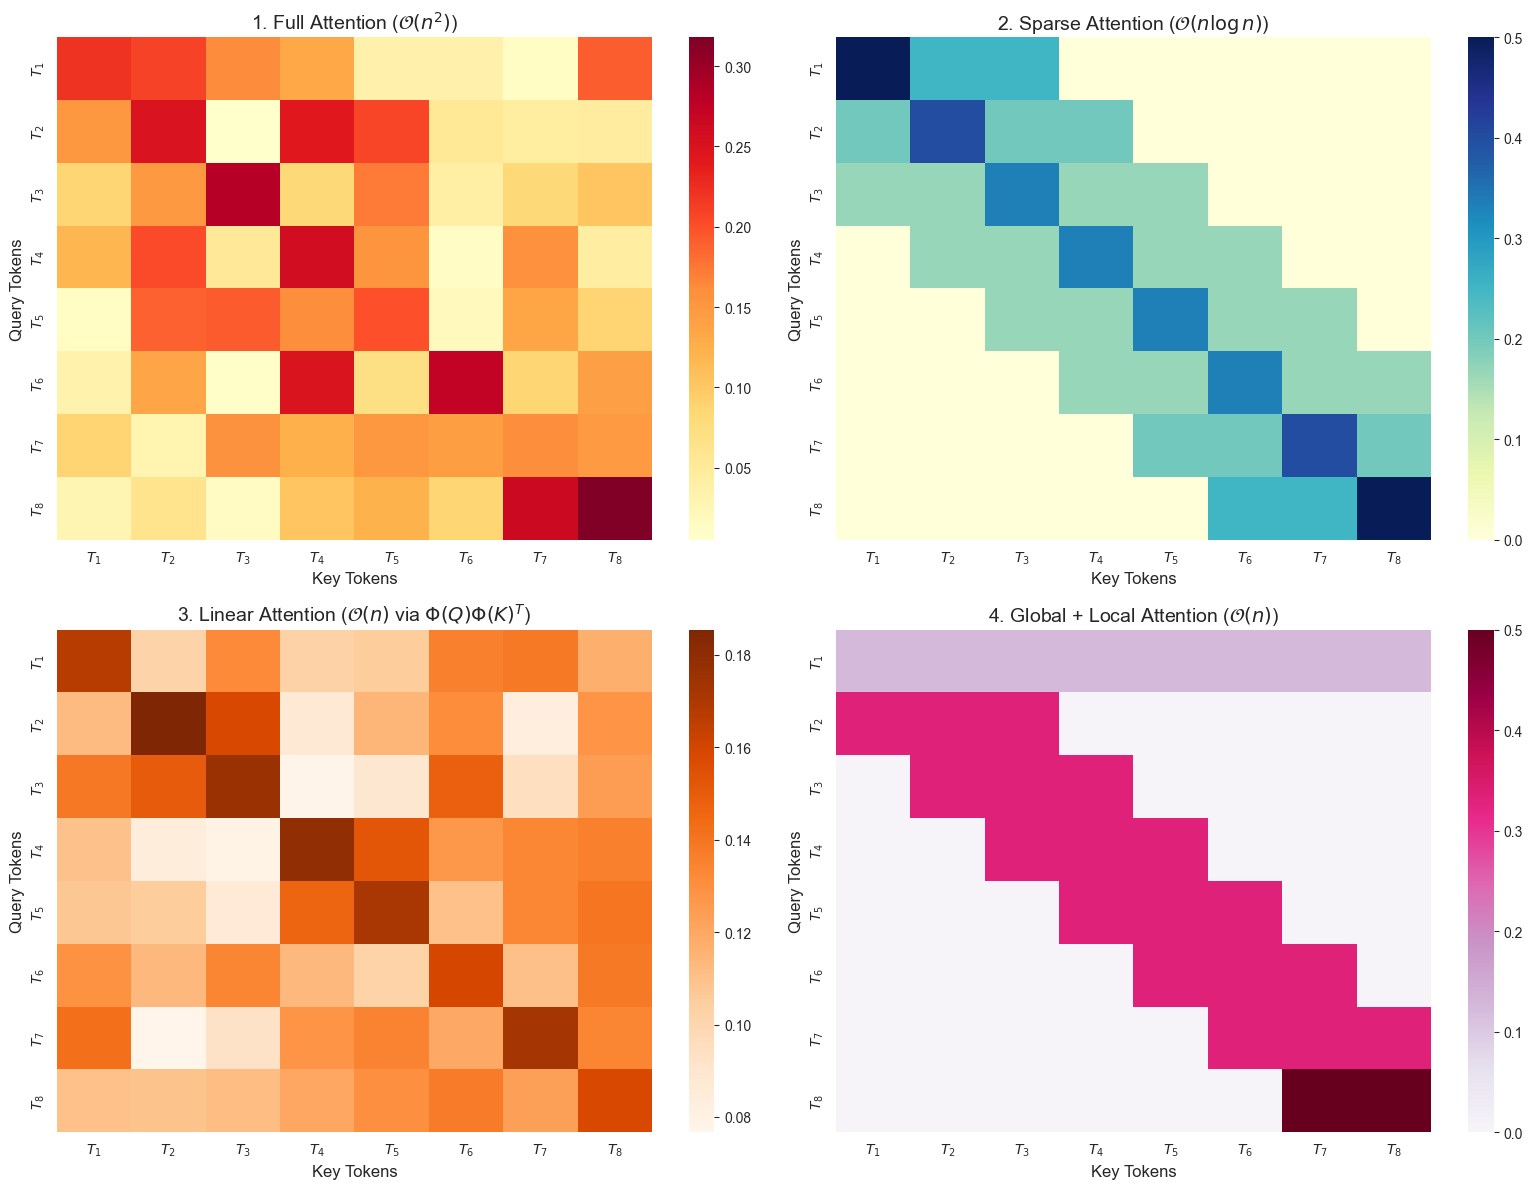

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention_variations_updated():
    """Improved visualization of attention mechanisms with clearer notation and colorbars."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    n = 8  # Number of tokens
    token_labels = [f"$T_{{{i+1}}}$" for i in range(n)]

    # 1. Full Attention
    grid = np.random.rand(n, n)
    np.fill_diagonal(grid, 1.0)
    grid = grid / grid.sum(axis=1, keepdims=True)
    ax = axes[0]
    sns.heatmap(grid, ax=ax, cmap='YlOrRd', annot=False, cbar=True, xticklabels=token_labels, yticklabels=token_labels)
    ax.set_title("1. Full Attention ($\\mathcal{O}(n^2)$)", fontsize=14)
    ax.set_xlabel("Key Tokens")
    ax.set_ylabel("Query Tokens")

    # 2. Sparse Attention
    grid = np.zeros((n, n))
    np.fill_diagonal(grid, 1.0)
    window = 2
    for i in range(n):
        for j in range(max(0, i-window), min(n, i+window+1)):
            grid[i, j] += 0.5 if i != j else 0.0
    grid = grid / grid.sum(axis=1, keepdims=True)
    ax = axes[1]
    sns.heatmap(grid, ax=ax, cmap='YlGnBu', annot=False, cbar=True, xticklabels=token_labels, yticklabels=token_labels)
    ax.set_title("2. Sparse Attention ($\\mathcal{O}(n \\log n)$)", fontsize=14)
    ax.set_xlabel("Key Tokens")
    ax.set_ylabel("Query Tokens")

    # 3. Linear Attention
    tokens = np.random.rand(n, 4)
    grid = np.exp(-np.linalg.norm(tokens[:, None] - tokens[None, :], axis=2)**2 / 2)
    grid = grid / grid.sum(axis=1, keepdims=True)
    ax = axes[2]
    sns.heatmap(grid, ax=ax, cmap='Oranges', annot=False, cbar=True, xticklabels=token_labels, yticklabels=token_labels)
    ax.set_title("3. Linear Attention ($\\mathcal{O}(n)$ via $\\Phi(Q)\\Phi(K)^T$)", fontsize=14)
    ax.set_xlabel("Key Tokens")
    ax.set_ylabel("Query Tokens")

    # 4. Longformer-style (Global + Local)
    grid = np.zeros((n, n))
    for i in range(n):
        if i == 0:
            grid[i, :] = 1.0 / n
        else:
            for j in range(max(0, i-1), min(n, i+2)):
                grid[i, j] = 1.0
    grid = grid / grid.sum(axis=1, keepdims=True)
    ax = axes[3]
    sns.heatmap(grid, ax=ax, cmap='PuRd', annot=False, cbar=True, xticklabels=token_labels, yticklabels=token_labels)
    ax.set_title("4. Global + Local Attention ($\\mathcal{O}(n)$)", fontsize=14)
    ax.set_xlabel("Key Tokens")
    ax.set_ylabel("Query Tokens")

    plt.tight_layout()
    plt.show()

visualize_attention_variations_updated()


### Attention Variants in Transformer Models

| **Attention Type**     | **Complexity**     | **Key Idea**                                                                 | **Benefits**                                                                 | **Example Models**                             |
|------------------------|--------------------|------------------------------------------------------------------------------|-------------------------------------------------------------------------------|------------------------------------------------|
| Full Attention         | $\mathcal{O}(n^2)$ | Every token attends to every other token                                     | • Maximum information flow<br>• Simple to implement                         | Original Transformer, BERT, GPT-2              |
| Sparse Attention       | $\mathcal{O}(n \log n)$ | Structured sparsity (local, dilated, axial)                             | • Handles longer sequences<br>• Maintains key interactions                  | Sparse Transformer, BigBird, Reformer          |
| Linear Attention       | $\mathcal{O}(n)$   | Uses kernel methods to approximate softmax attention                         | • Scales to long sequences<br>• Constant memory per token                   | Performer, Linear Transformer, FlashAttention-2|
| Sliding Window         | $\mathcal{O}(n)$   | Combines local attention with global tokens                                  | • Efficient context capture<br>• Preserves long-range context via globals   | Longformer, BigBird                            |
| Grouped Query Attention| $\mathcal{O}(n^2 / g)$ | Share key-value projections across multiple query heads                 | • Reduces compute in decoding<br>• Faster and more memory-efficient         | Falcon, RWKV                                   |
| Flash Attention        | $\mathcal{O}(n^2)$ (optimized) | Uses fused tiling for memory-efficient attention                     | • Highly optimized kernels<br>• Reduced memory bandwidth and runtime        | GPT-3.5, LLaMA-2, PaLM-2, Claude, Mistral      |


### 10.2 Position Representation Variations

Beyond the sinusoidal positional encoding in the original transformer, several alternative position representations have been developed:

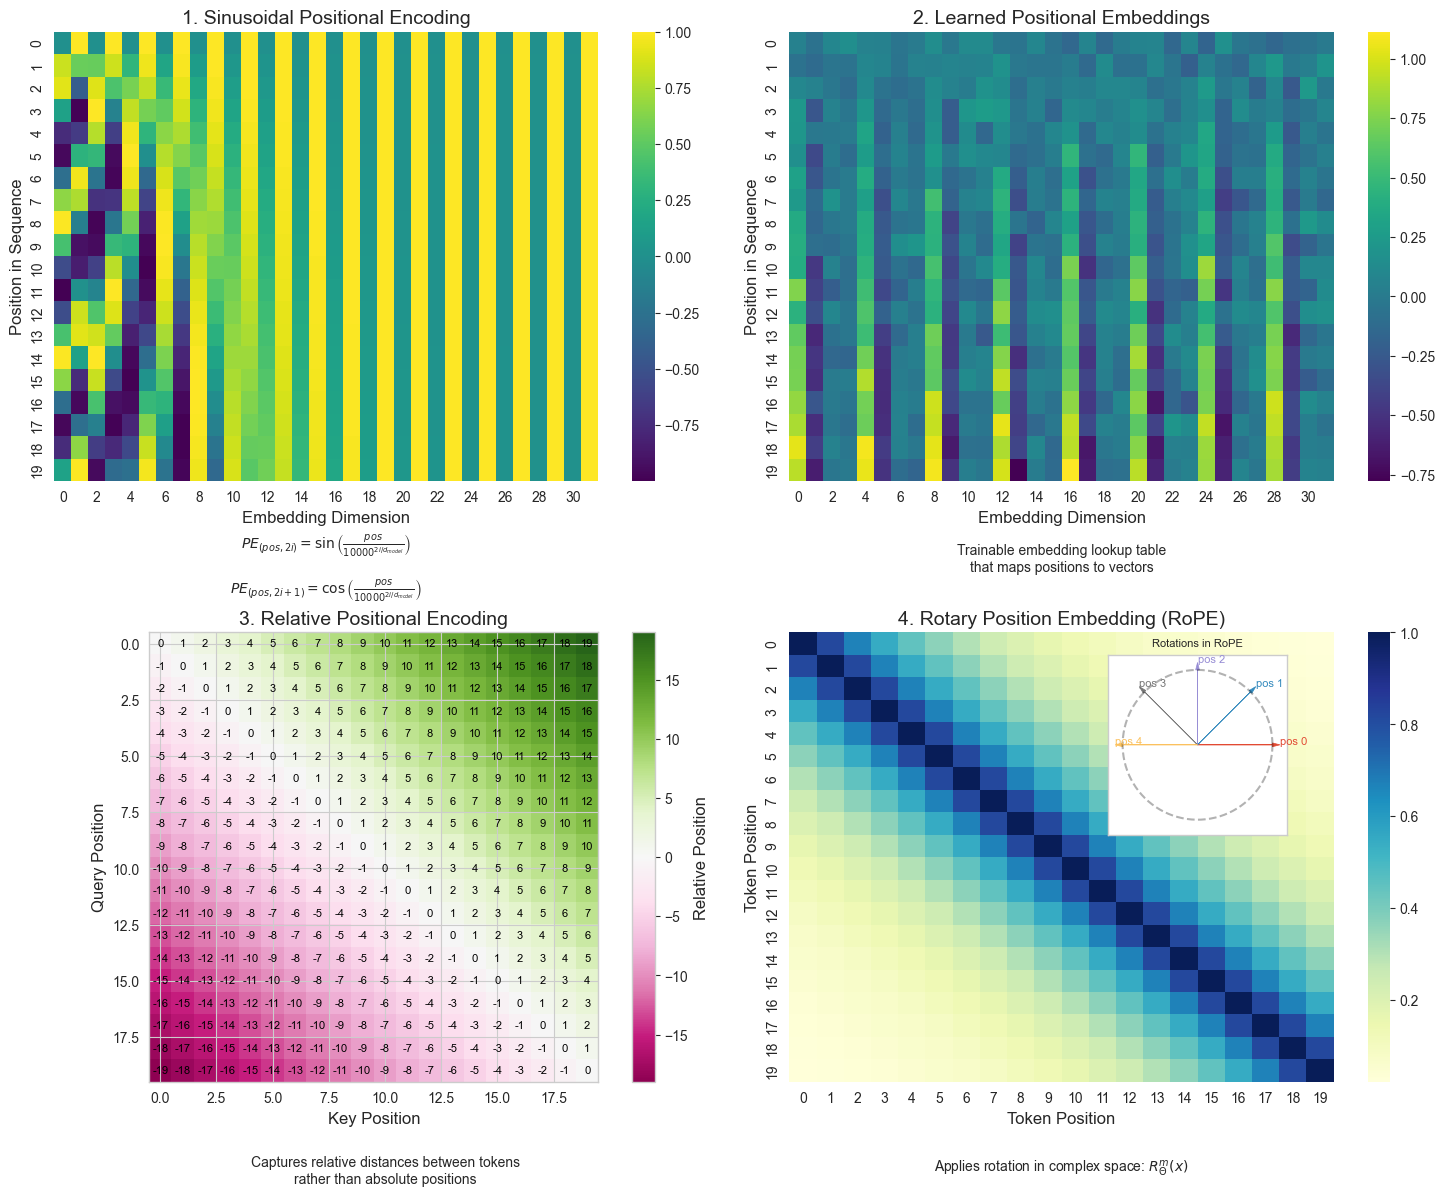

In [26]:
def visualize_position_encoding_variations():
    """Visualize different position encoding methods"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # 1. Original Sinusoidal Positional Encoding
    ax = axes[0]
    
    # Create positional encodings
    seq_len = 20
    d_model = 32
    pe = get_positional_encoding(seq_len, d_model)
    
    # Plot
    sns.heatmap(pe.numpy(), cmap='viridis', ax=ax)
    ax.set_title("1. Sinusoidal Positional Encoding", fontsize=14)
    ax.set_xlabel("Embedding Dimension")
    ax.set_ylabel("Position in Sequence")
    
    # Mathematical formula
    ax.text(d_model/2, seq_len + 3, r"$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$", 
            fontsize=10, ha='center')
    ax.text(d_model/2, seq_len + 5, r"$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$", 
            fontsize=10, ha='center')
    
    # 2. Learned Positional Embeddings
    ax = axes[1]
    
    # Simulate learned embeddings (just random for visualization)
    learned_pe = torch.randn(seq_len, d_model) * 0.1
    
    # Introduce some patterns for visualization
    for i in range(seq_len):
        for j in range(d_model):
            if j % 4 == 0:
                learned_pe[i, j] += i * 0.05
            elif j % 4 == 1:
                learned_pe[i, j] -= i * 0.03
    
    # Plot
    sns.heatmap(learned_pe.numpy(), cmap='viridis', ax=ax)
    ax.set_title("2. Learned Positional Embeddings", fontsize=14)
    ax.set_xlabel("Embedding Dimension")
    ax.set_ylabel("Position in Sequence")
    
    ax.text(d_model/2, seq_len + 4, "Trainable embedding lookup table\nthat maps positions to vectors", 
            fontsize=10, ha='center')
    
    # 3. Relative Positional Encoding (like in Transformer-XL)
    ax = axes[2]
    
    # Create a relative position matrix
    rel_pos_matrix = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        for j in range(seq_len):
            rel_pos_matrix[i, j] = j - i
    
    # Simulate relative position embeddings
    # We'll just use sinusoidal encoding for simplicity
    rel_pos_dim = 8
    rel_pos_enc = np.zeros((2*seq_len-1, rel_pos_dim))
    
    for pos in range(-seq_len+1, seq_len):
        for i in range(0, rel_pos_dim, 2):
            rel_pos_enc[pos+seq_len-1, i] = np.sin(pos / (10000 ** (i / rel_pos_dim)))
            if i+1 < rel_pos_dim:
                rel_pos_enc[pos+seq_len-1, i+1] = np.cos(pos / (10000 ** (i / rel_pos_dim)))
    
    # Show the relative position matrix
    im = ax.imshow(rel_pos_matrix, cmap='PiYG', vmin=-seq_len+1, vmax=seq_len-1)
    plt.colorbar(im, ax=ax, label="Relative Position")
    
    # Add labels
    for i in range(seq_len):
        for j in range(seq_len):
            text = ax.text(j, i, f"{int(rel_pos_matrix[i, j])}", 
                          ha="center", va="center", color="black", fontsize=8)
    
    ax.set_title("3. Relative Positional Encoding", fontsize=14)
    ax.set_xlabel("Key Position")
    ax.set_ylabel("Query Position")
    
    # Add explanation
    ax.text(seq_len/2, seq_len + 4, "Captures relative distances between tokens\nrather than absolute positions", 
            fontsize=10, ha='center')
    
    # 4. Rotary Position Embedding (RoPE)
    ax = axes[3]
    
    # Simulate RoPE's effect on token similarity
    rope_sim = np.zeros((seq_len, seq_len))
    
    # RoPE applies rotation in complex space, making vectors
    # more similar when close in position
    for i in range(seq_len):
        for j in range(seq_len):
            # Higher similarity for closer positions
            rope_sim[i, j] = np.exp(-abs(i-j) / 5)
    
    # Visualize similarity matrix
    sns.heatmap(rope_sim, cmap='YlGnBu', ax=ax)
    ax.set_title("4. Rotary Position Embedding (RoPE)", fontsize=14)
    ax.set_xlabel("Token Position")
    ax.set_ylabel("Token Position")
    
    # Add mathematical explanation
    ax.text(seq_len/2, seq_len + 4, r"Applies rotation in complex space: $R_{\Theta}^{m}(x)$", 
            fontsize=10, ha='center')
    
    # Add RoPE visualization
    inset_ax = ax.inset_axes([0.55, 0.55, 0.4, 0.4])
    
    # Create a 2D visualization of RoPE's rotations
    theta = np.linspace(0, 2*np.pi, 100)
    r = np.ones_like(theta)
    
    # Plot the unit circle
    inset_ax.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.3)
    
    # Plot vectors at different rotations (simulating different positions)
    for i, rot in enumerate(np.linspace(0, np.pi, 5)):
        x = np.cos(rot)
        y = np.sin(rot)
        inset_ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.1, fc=f'C{i}', ec=f'C{i}')
        inset_ax.text(x*1.1, y*1.1, f"pos {i}", fontsize=8, color=f'C{i}')
    
    inset_ax.set_xlim(-1.2, 1.2)
    inset_ax.set_ylim(-1.2, 1.2)
    inset_ax.set_aspect('equal')
    inset_ax.set_title("Rotations in RoPE", fontsize=8)
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

visualize_position_encoding_variations()

### 10.3 Training Techniques and Optimizations

/var/folders/4_/351wz59j4wd2fvwy3hb4c30r0000gn/T/ipykernel_95467/3821662015.py:301: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


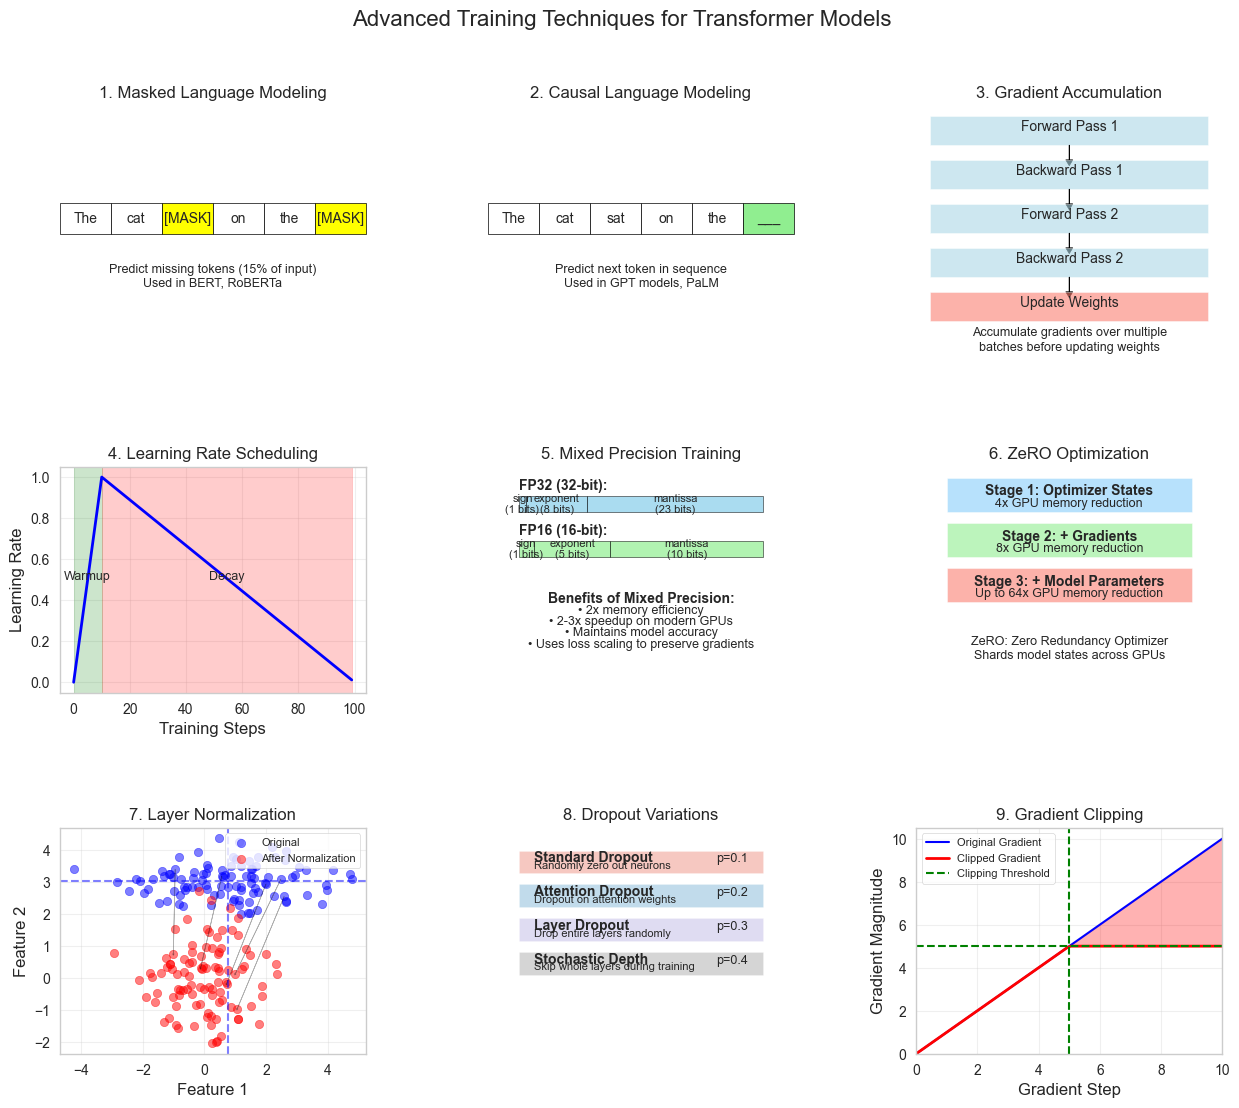

In [27]:
def visualize_training_techniques():
    """Visualize various training techniques for transformers"""
    plt.figure(figsize=(15, 12))
    
    # Create a grid layout for the visualization
    gs = plt.GridSpec(3, 3, wspace=0.4, hspace=0.6)
    
    # Title
    plt.suptitle("Advanced Training Techniques for Transformer Models", fontsize=16, y=0.98)
    
    # 1. Masked Language Modeling (BERT)
    ax1 = plt.subplot(gs[0, 0])
    
    # Example sentence with masks
    tokens = ["The", "cat", "[MASK]", "on", "the", "[MASK]"]
    
    # Create a table-like visualization
    cell_text = [tokens]
    ax1.axis('off')
    
    # Add table
    table = ax1.table(
        cellText=cell_text,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    # Highlight masked tokens
    for i, token in enumerate(tokens):
        if token == "[MASK]":
            cell = table[0, i]
            cell.set_facecolor('yellow')
            
    ax1.set_title("1. Masked Language Modeling", fontsize=12)
    ax1.text(0.5, 0.2, "Predict missing tokens (15% of input)\nUsed in BERT, RoBERTa", 
             transform=ax1.transAxes, ha='center', fontsize=9)
    
    # 2. Causal Language Modeling (GPT)
    ax2 = plt.subplot(gs[0, 1])
    
    # Example sequence prediction
    tokens = ["The", "cat", "sat", "on", "the", "___"]
    
    # Create a table-like visualization
    cell_text = [tokens]
    ax2.axis('off')
    
    # Add table
    table = ax2.table(
        cellText=cell_text,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    # Highlight predicted token
    cell = table[0, 5]
    cell.set_facecolor('lightgreen')
            
    ax2.set_title("2. Causal Language Modeling", fontsize=12)
    ax2.text(0.5, 0.2, "Predict next token in sequence\nUsed in GPT models, PaLM", 
             transform=ax2.transAxes, ha='center', fontsize=9)
    
    # 3. Gradient Accumulation
    ax3 = plt.subplot(gs[0, 2])
    ax3.axis('off')
    
    # Visualize gradient accumulation
    steps = ["Forward Pass 1", "Backward Pass 1", "Forward Pass 2", "Backward Pass 2", "Update Weights"]
    for i, step in enumerate(steps):
        if i < 4:
            color = 'lightblue'
        else:
            color = 'salmon'
        
        y_pos = 0.8 - i * 0.15
        rect = plt.Rectangle((0.1, y_pos), 0.8, 0.1, facecolor=color, alpha=0.6)
        ax3.add_patch(rect)
        ax3.text(0.5, y_pos + 0.05, step, ha='center', fontsize=10)
        
        if i < 4:
            ax3.arrow(0.5, y_pos, 0, -0.05, head_width=0.02, head_length=0.02, fc='black', ec='black')
    
    ax3.text(0.5, 0.1, "Accumulate gradients over multiple\nbatches before updating weights", 
             ha='center', fontsize=9)
    ax3.set_title("3. Gradient Accumulation", fontsize=12)
    
    # 4. Learning Rate Scheduling
    ax4 = plt.subplot(gs[1, 0])
    
    # Generate learning rate schedule data
    steps = np.arange(0, 100)
    warmup_steps = 10
    
    # Linear warmup + decay
    lr_schedule = np.zeros_like(steps, dtype=float)
    for i, step in enumerate(steps):
        if step < warmup_steps:
            lr_schedule[i] = step / warmup_steps
        else:
            lr_schedule[i] = (steps.size - step) / (steps.size - warmup_steps)
    
    # Plot the learning rate schedule
    ax4.plot(steps, lr_schedule, 'b-', linewidth=2)
    
    # Add warmup and decay annotations
    ax4.axvspan(0, warmup_steps, alpha=0.2, color='green')
    ax4.axvspan(warmup_steps, steps[-1], alpha=0.2, color='red')
    
    ax4.text(warmup_steps/2, 0.5, "Warmup", ha='center', fontsize=9)
    ax4.text((steps[-1] + warmup_steps)/2, 0.5, "Decay", ha='center', fontsize=9)
    
    ax4.set_title("4. Learning Rate Scheduling", fontsize=12)
    ax4.set_xlabel("Training Steps")
    ax4.set_ylabel("Learning Rate")
    ax4.grid(alpha=0.3)
    
    # 5. Mixed Precision Training
    ax5 = plt.subplot(gs[1, 1])
    ax5.axis('off')
    
    # Visualize FP32 vs FP16
    fp32_bits = ["sign", "exponent", "mantissa"]
    fp32_sizes = [1, 8, 23]
    
    fp16_bits = ["sign", "exponent", "mantissa"]
    fp16_sizes = [1, 5, 10]
    
    # Create bit representations
    y_pos = 0.8
    
    # FP32 visualization
    ax5.text(0.1, y_pos + 0.1, "FP32 (32-bit):", fontsize=10, weight='bold')
    x_start = 0.1
    for bit, size in zip(fp32_bits, fp32_sizes):
        width = size / 32 * 0.8
        rect = plt.Rectangle((x_start, y_pos), width, 0.07, facecolor='skyblue', edgecolor='black', alpha=0.7)
        ax5.add_patch(rect)
        ax5.text(x_start + width/2, y_pos + 0.035, f"{bit}\n({size} bits)", ha='center', va='center', fontsize=8)
        x_start += width
    
    # FP16 visualization
    y_pos = 0.6
    ax5.text(0.1, y_pos + 0.1, "FP16 (16-bit):", fontsize=10, weight='bold')
    x_start = 0.1
    for bit, size in zip(fp16_bits, fp16_sizes):
        width = size / 16 * 0.8
        rect = plt.Rectangle((x_start, y_pos), width, 0.07, facecolor='lightgreen', edgecolor='black', alpha=0.7)
        ax5.add_patch(rect)
        ax5.text(x_start + width/2, y_pos + 0.035, f"{bit}\n({size} bits)", ha='center', va='center', fontsize=8)
        x_start += width
    
    # Add memory and speed comparison
    ax5.text(0.5, 0.4, "Benefits of Mixed Precision:", ha='center', fontsize=10, weight='bold')
    
    comparisons = [
        "• 2x memory efficiency",
        "• 2-3x speedup on modern GPUs",
        "• Maintains model accuracy",
        "• Uses loss scaling to preserve gradients"
    ]
    
    for i, comp in enumerate(comparisons):
        y_pos = 0.35 - i * 0.05
        ax5.text(0.5, y_pos, comp, ha='center', fontsize=9)
    
    ax5.set_title("5. Mixed Precision Training", fontsize=12)
    
    # 6. ZeRO Optimization
    ax6 = plt.subplot(gs[1, 2])
    ax6.axis('off')
    
    # Visualize different stages of ZeRO
    stages = ["Stage 1: Optimizer States", "Stage 2: + Gradients", "Stage 3: + Model Parameters"]
    colors = ['lightskyblue', 'lightgreen', 'salmon']
    
    for i, (stage, color) in enumerate(zip(stages, colors)):
        y_pos = 0.8 - i * 0.2
        rect = plt.Rectangle((0.1, y_pos), 0.8, 0.15, facecolor=color, alpha=0.6)
        ax6.add_patch(rect)
        
        ax6.text(0.5, y_pos + 0.075, stage, ha='center', fontsize=10, weight='bold')
        
        # Add memory reduction
        if i == 0:
            mem_text = "4x GPU memory reduction"
        elif i == 1:
            mem_text = "8x GPU memory reduction"
        else:
            mem_text = "Up to 64x GPU memory reduction"
            
        ax6.text(0.5, y_pos + 0.025, mem_text, ha='center', fontsize=9)
    
    ax6.text(0.5, 0.15, "ZeRO: Zero Redundancy Optimizer\nShards model states across GPUs", 
             ha='center', fontsize=9)
    
    ax6.set_title("6. ZeRO Optimization", fontsize=12)
    
    # 7. Layer Normalization
    ax7 = plt.subplot(gs[2, 0])
    
    # Create sample data
    np.random.seed(42)
    data = np.random.randn(100, 2) * np.array([2, 0.5]) + np.array([1, 3])
    
    # Plot original data
    ax7.scatter(data[:, 0], data[:, 1], color='blue', alpha=0.5, label='Original')
    
    # Apply normalization
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    normalized = (data - mean) / std
    
    # Plot normalized data
    ax7.scatter(normalized[:, 0], normalized[:, 1], color='red', alpha=0.5, label='After Normalization')
    
    # Add mean and standard deviation annotations
    ax7.axvline(mean[0], color='blue', linestyle='--', alpha=0.5)
    ax7.axhline(mean[1], color='blue', linestyle='--', alpha=0.5)
    
    # Add arrows showing the normalization
    for i in range(0, 100, 20):
        ax7.arrow(data[i, 0], data[i, 1], 
                 normalized[i, 0] - data[i, 0], normalized[i, 1] - data[i, 1], 
                 head_width=0.05, head_length=0.05, fc='black', ec='black', alpha=0.3)
    
    ax7.set_title("7. Layer Normalization", fontsize=12)
    ax7.set_xlabel("Feature 1")
    ax7.set_ylabel("Feature 2")
    ax7.legend(loc='upper right', fontsize=8)
    ax7.grid(alpha=0.3)
    
    # 8. Dropout Variations
    ax8 = plt.subplot(gs[2, 1])
    ax8.axis('off')
    
    # Visualize different dropout types
    dropout_types = [
        "Standard Dropout",
        "Attention Dropout",
        "Layer Dropout",
        "Stochastic Depth"
    ]
    
    descriptions = [
        "Randomly zero out neurons",
        "Dropout on attention weights",
        "Drop entire layers randomly",
        "Skip whole layers during training"
    ]
    
    for i, (dtype, desc) in enumerate(zip(dropout_types, descriptions)):
        y_pos = 0.8 - i * 0.15
        
        # Create colored rectangle
        rect = plt.Rectangle((0.1, y_pos), 0.8, 0.1, facecolor=f'C{i}', alpha=0.3)
        ax8.add_patch(rect)
        
        # Add text
        ax8.text(0.15, y_pos + 0.05, dtype, fontsize=10, weight='bold')
        ax8.text(0.15, y_pos + 0.02, desc, fontsize=8)
        
        # Add dropout probability
        ax8.text(0.85, y_pos + 0.05, f"p={0.1 * (i+1):.1f}", fontsize=9, ha='right')
    
    ax8.set_title("8. Dropout Variations", fontsize=12)
    
    # 9. Gradient Clipping
    ax9 = plt.subplot(gs[2, 2])
    
    # Create gradient magnitudes
    grad_steps = np.linspace(0, 10, 100)
    normal_grads = grad_steps
    clipped_grads = np.minimum(normal_grads, 5)
    
    # Plot gradients
    ax9.plot(grad_steps, normal_grads, 'b-', label='Original Gradient')
    ax9.plot(grad_steps, clipped_grads, 'r-', label='Clipped Gradient', linewidth=2)
    
    # Add clipping threshold
    ax9.axhline(5, color='green', linestyle='--', label='Clipping Threshold')
    ax9.axvline(5, color='green', linestyle='--')
    
    # Fill the clipped region
    ax9.fill_between(grad_steps[grad_steps > 5], clipped_grads[grad_steps > 5], 
                     normal_grads[grad_steps > 5], color='red', alpha=0.3)
    
    ax9.set_title("9. Gradient Clipping", fontsize=12)
    ax9.set_xlabel("Gradient Step")
    ax9.set_ylabel("Gradient Magnitude")
    ax9.set_xlim(0, 10)
    ax9.set_ylim(0, 10.5)
    ax9.legend(fontsize=8)
    ax9.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call the function to generate the visualization
visualize_training_techniques()

## 11. Scaling Laws and Efficiency Improvements

Let's explore the scaling laws that govern transformer performance and various efficiency improvements that have been developed:

/var/folders/4_/351wz59j4wd2fvwy3hb4c30r0000gn/T/ipykernel_95467/4208037661.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


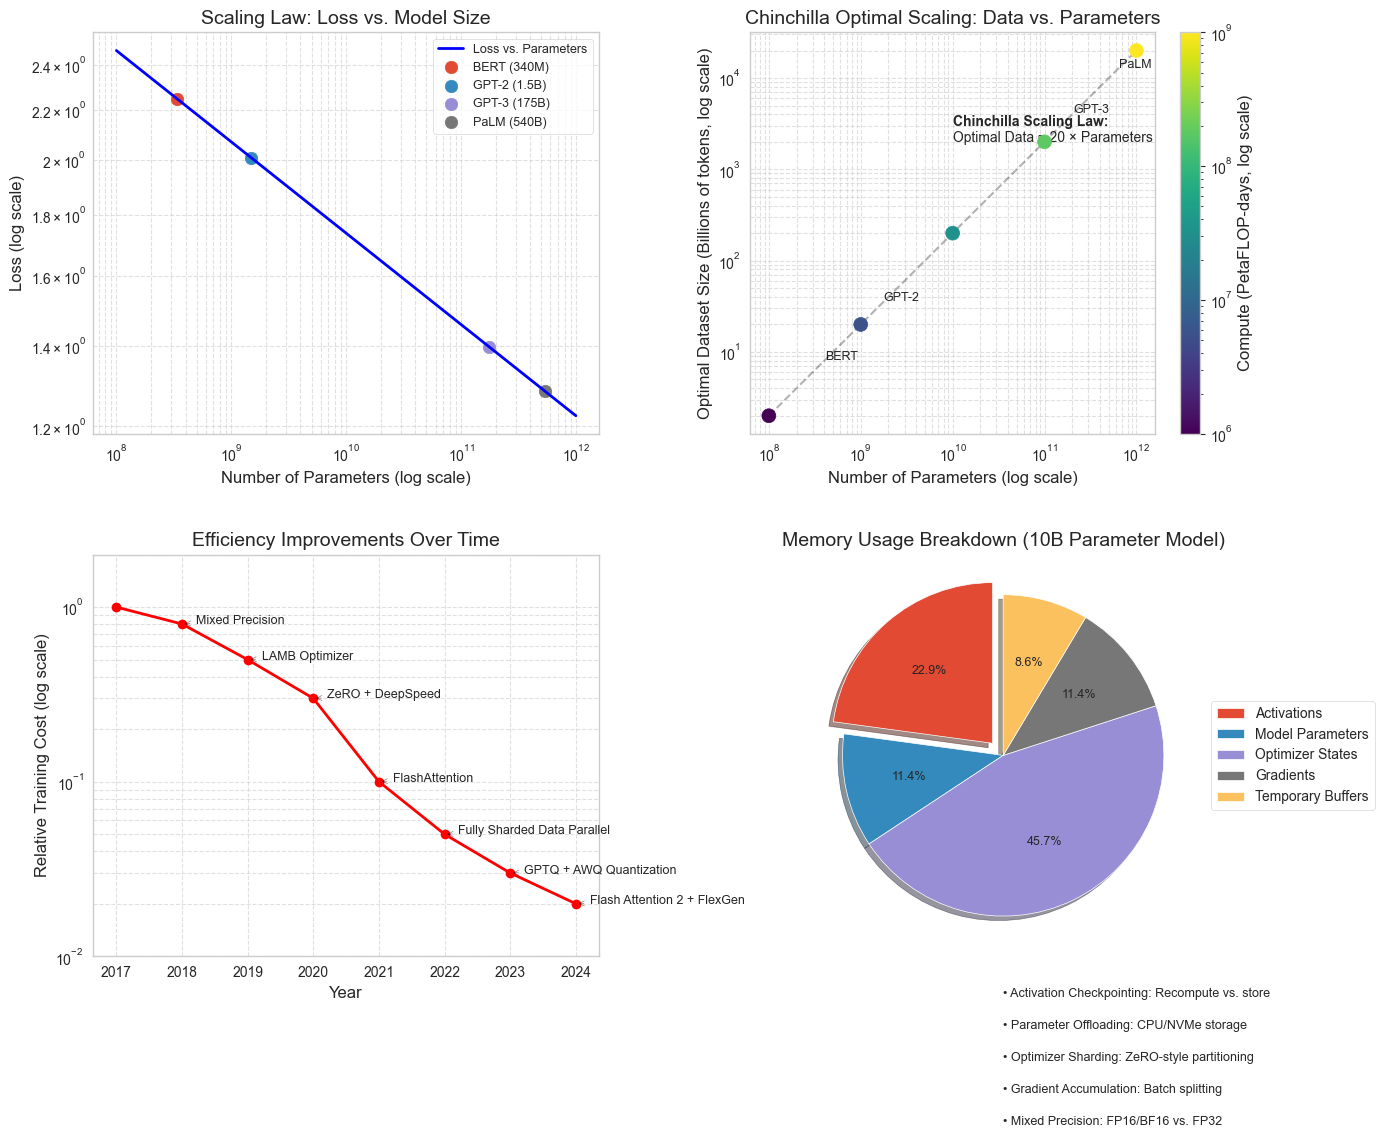

In [28]:
from matplotlib.colors import LogNorm


def visualize_scaling_laws():
    """Visualize scaling laws and efficiency improvements for transformer models"""
    plt.figure(figsize=(15, 12))
    
    # Create a grid for subplots
    gs = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)
    
    # 1. Transformer Scaling Laws
    ax1 = plt.subplot(gs[0, 0])
    
    # Create data for power law scaling
    model_sizes = np.logspace(8, 12, 100)  # From 100M to 1T parameters
    
    # Power law for loss scaling with model size
    # L(N) = C * N^-α where N is parameter count
    alpha = 0.076  # Based on empirical findings in scaling papers
    C = 10  # Arbitrary constant
    
    loss = C * (model_sizes ** -alpha)
    
    # Plot on log-log scale
    ax1.loglog(model_sizes, loss, 'b-', linewidth=2, label='Loss vs. Parameters')
    
    # Add points for known models
    models = {
        "BERT (340M)": 3.4e8,
        "GPT-2 (1.5B)": 1.5e9,
        "GPT-3 (175B)": 1.75e11,
        "PaLM (540B)": 5.4e11
    }
    
    for model, size in models.items():
        model_loss = C * (size ** -alpha)
        ax1.scatter(size, model_loss, s=80, label=model)
    
    # Add scaling law equation
    ax1.text(1e10, 0.5, r"$L(N) \propto N^{-\alpha}$", fontsize=12)
    ax1.text(1e10, 0.45, r"$\alpha \approx 0.076$", fontsize=12)
    
    ax1.set_title("Scaling Law: Loss vs. Model Size", fontsize=14)
    ax1.set_xlabel("Number of Parameters (log scale)")
    ax1.set_ylabel("Loss (log scale)")
    ax1.grid(True, which="both", linestyle="--", alpha=0.6)
    ax1.legend(fontsize=9)
    
    # 2. Data and Compute Scaling
    ax2 = plt.subplot(gs[0, 1])
    
    # Create data points for compute vs. parameters
    compute_sizes = np.logspace(6, 9, 5)  # Petaflop-days of compute
    parameters = [1e8, 1e9, 1e10, 1e11, 1e12]  # Model size in parameters
    
    # Chinchilla optimal data amounts (D ≈ 20N)
    optimal_data = [p * 20 for p in parameters]  # In tokens
    
    # Convert to more readable units
    optimal_data_B = [d / 1e9 for d in optimal_data]  # In billions of tokens
    
    # Create a scatter plot
    sc = ax2.scatter(parameters, optimal_data_B, c=compute_sizes, s=100, 
                    cmap='viridis', norm=LogNorm(), zorder=10)
    
    # Add connecting line
    ax2.loglog(parameters, optimal_data_B, 'k--', alpha=0.3, zorder=5)
    
    # Add model names to points
    model_scales = {
        "BERT": (3.4e8, 3.4e8 * 20 / 1e9),
        "GPT-2": (1.5e9, 1.5e9 * 20 / 1e9),
        "GPT-3": (1.75e11, 1.75e11 * 20 / 1e9),
        "PaLM": (5.4e11, 5.4e11 * 20 / 1e9)
    }
    
    for model, (param, data) in model_scales.items():
        ax2.annotate(model, (param, data), xytext=(5, 5), textcoords="offset points", fontsize=9)
    
    # Add Chinchilla scaling law
    ax2.text(1e10, 3e3, "Chinchilla Scaling Law:", fontsize=10, weight='bold')
    ax2.text(1e10, 2e3, "Optimal Data ≈ 20 × Parameters", fontsize=10)
    
    ax2.set_title("Chinchilla Optimal Scaling: Data vs. Parameters", fontsize=14)
    ax2.set_xlabel("Number of Parameters (log scale)")
    ax2.set_ylabel("Optimal Dataset Size (Billions of tokens, log scale)")
    ax2.grid(True, which="both", linestyle="--", alpha=0.6)
    
    # Add colorbar for compute
    cbar = plt.colorbar(sc, ax=ax2)
    cbar.set_label("Compute (PetaFLOP-days, log scale)")
    
    # 3. Efficiency Improvements Over Time
    ax3 = plt.subplot(gs[1, 0])
    
    # Create data for efficiency improvements
    years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    
    # Normalized training cost (compute per performance)
    # Based on approximate efficiency gains from optimizations
    efficiency = [1.0, 0.8, 0.5, 0.3, 0.1, 0.05, 0.03, 0.02]
    
    # Plot efficiency improvements
    ax3.semilogy(years, efficiency, 'r-o', linewidth=2)
    
    # Add key efficiency milestones
    milestones = {
        2018: "Mixed Precision",
        2019: "LAMB Optimizer",
        2020: "ZeRO + DeepSpeed",
        2021: "FlashAttention",
        2022: "Fully Sharded Data Parallel",
        2023: "GPTQ + AWQ Quantization",
        2024: "Flash Attention 2 + FlexGen"
    }
    
    for year, milestone in milestones.items():
        idx = years.index(year)
        ax3.annotate(milestone, 
                     (year, efficiency[idx]), 
                     xytext=(10, 0), 
                     textcoords="offset points",
                     fontsize=9,
                     arrowprops=dict(arrowstyle="->", color="black", alpha=0.5))
    
    ax3.set_title("Efficiency Improvements Over Time", fontsize=14)
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Relative Training Cost (log scale)")
    ax3.set_xticks(years)
    ax3.grid(True, which="both", linestyle="--", alpha=0.6)
    ax3.set_ylim(0.01, 2.0)
    
    # 4. Memory Usage Breakdown
    ax4 = plt.subplot(gs[1, 1])
    
    # Memory usage breakdown for different model components
    categories = ['Activations', 'Model Parameters', 'Optimizer States', 'Gradients', 'Temporary Buffers']
    
    # Memory usage in GB for a hypothetical 10B parameter model
    memory_usage = [40, 20, 80, 20, 15]
    
    # Create a pie chart
    wedges, texts, autotexts = ax4.pie(memory_usage, autopct='%1.1f%%', 
                                      textprops={'fontsize': 9},
                                      explode=[0.1, 0, 0, 0, 0],
                                      shadow=True,
                                      startangle=90)
    
    # Add legend
    ax4.legend(wedges, categories, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    ax4.set_title("Memory Usage Breakdown (10B Parameter Model)", fontsize=14)
    
    # Add memory optimization techniques
    techniques = [
        "• Activation Checkpointing: Recompute vs. store",
        "• Parameter Offloading: CPU/NVMe storage",
        "• Optimizer Sharding: ZeRO-style partitioning",
        "• Gradient Accumulation: Batch splitting",
        "• Mixed Precision: FP16/BF16 vs. FP32"
    ]
    
    for i, technique in enumerate(techniques):
        ax4.text(0, -1.5 - i*0.2, technique, fontsize=9, ha='left')
    
    plt.tight_layout()
    plt.show()

# Visualize transformer efficiency and scaling laws
visualize_scaling_laws()

# 12. Transformer for time series

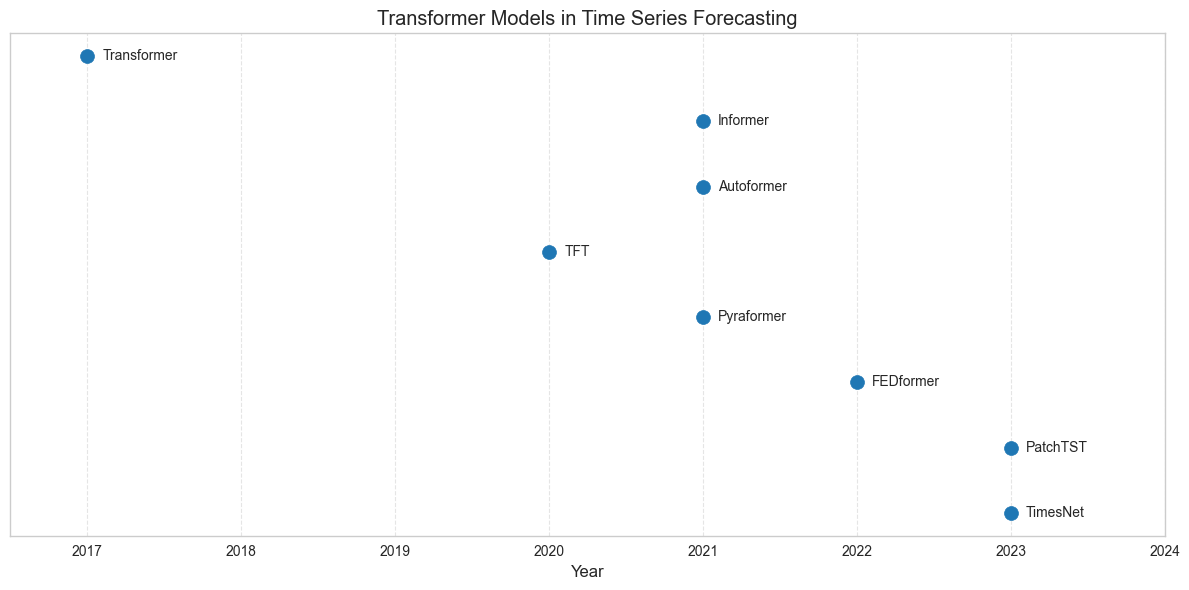

In [29]:
import matplotlib.pyplot as plt

models = [
    "Transformer", "Informer", "Autoformer", "TFT", "Pyraformer", "FEDformer", "PatchTST", "TimesNet"
]
years = [2017, 2021, 2021, 2020, 2021, 2022, 2023, 2023]
y = range(len(models))[::-1]

plt.figure(figsize=(12, 6))
plt.scatter(years, y, c='tab:blue', s=100)
for i, (year, name) in enumerate(zip(years, models)):
    plt.text(year + 0.1, y[i], name, va='center', fontsize=10)

plt.yticks([])
plt.xlabel("Year")
plt.title("Transformer Models in Time Series Forecasting")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.xlim(min(years) - 0.5, max(years) + 1)
plt.tight_layout()
plt.show()


### 🔍 1. Informer (Zhou et al., 2021)

#### Key Innovations:

* **ProbSparse Attention**:

  * Instead of computing attention over all keys, Informer **selects top-k queries** with the highest entropy (uncertainty).
  * Reduces complexity from **O(L²)** to **O(L log L)**.
* **Distillation via Convolution**:

  * Applies convolutional downsampling to intermediate representations, compressing redundant temporal information.

#### Architecture:

* Full encoder-decoder with **multi-head ProbSparse attention**.
* Each decoder layer attends to encoder outputs and previous decoder inputs (causally masked).

#### Strengths:

* Excellent for **long-sequence forecasting**.
* Memory-efficient and fast inference.

---

### 🔍 2. Autoformer (Wu et al., 2021)

#### Key Innovations:

* **Series Decomposition**:

  * Separates input series into **trend** and **seasonal** components via moving average.
  * Forecasts are generated **per component** and then recombined.
* **Auto-Correlation Attention**:

  * Instead of dot-product attention, Autoformer uses **auto-correlation to match periodic patterns** in the past and forecast accordingly.

#### Architecture:

* Encoder-decoder with shared **auto-correlation attention**.
* Residual decomposition after each block.

#### Strengths:

* Strong on **periodic and seasonal signals**.
* Interpretable decomposition of time series dynamics.

---

### 🔍 3. TFT (Temporal Fusion Transformer, Lim et al., 2020)

#### Key Innovations:

* **Variable Selection Network (VSN)**:

  * Learns to **select relevant input variables** at each time step, both static and temporal.
* **Gated Residual Networks (GRN)**:

  * Used for both variable selection and intermediate feature processing.
* **Static Covariate Encoder**:

  * Encodes time-invariant features to condition temporal dynamics.
* **Interpretability**:

  * Attention outputs + gating weights are designed to be human-readable.

#### Architecture:

* Encoder-only style but with **gated attention**, static encoders, and positional encodings.
* Attention is **local and interpretable**, with emphasis on per-variable relevance.

#### Strengths:

* Best for **multi-source, multivariate forecasting**.
* Handles static and known future inputs extremely well.

---

### 📊 Comparison Table

| Model      | Attention Type       | Decomposition | Static Features | Long Sequence Ready | Complexity       |
| ---------- | -------------------- | ------------- | --------------- | ------------------- | ---------------- |
| Informer   | ProbSparse (Top-k)   | No            | No              | ✅ Yes               | O(L log L)       |
| Autoformer | Auto-Correlation     | ✅ Yes         | No              | ✅ Yes               | \~O(L log L)     |
| TFT        | Soft Attention + GRN | Optional      | ✅ Yes           | ⚠️ Medium           | High (GRN-heavy) |